# Modeling Harmful Algal Blooms in Southwest Florida: The Role of the Caloosahatchee River

This research investigates the potential for predicting Harmful Algal Blooms (HABs) along the Southwest Florida coast using a suite of environmental indicators. Key variables include nutrient concentrations (total nitrogen and total phosphorus), river discharge from the Caloosahatchee River, sea surface temperature (SST), wind speed and direction, and precipitation. 

The Caloosahatchee River is a particularly important system to examine due to its role as a major conduit of freshwater and nutrients into the Gulf of America, where red tide events frequently occur. Its well-documented discharge history and proximity to coastal monitoring stations make it an ideal location for exploring land-sea interactions. 

Environmental datasets are temporally and spatially aligned with observed HAB events, as reported by NOAA’s Harmful Algal Bloom Observing System (HABSOS), to train a supervised classification model. A logistic regression approach is used to quantify the relationship between environmental drivers and the probability of HAB occurrence. The goal is to evaluate the predictive value of routinely monitored parameters in supporting early-warning efforts and informing coastal management strategies.

## 1. Discharge Monitoring at S.R.-79 on the Caloosahatchee River

### 1.1 Selecting Discharge Station on Caloosahatchee River

The USGS site number 02292900 corresponds to the streamflow monitoring station at the Caloosahatchee River at S.R.-79 near Olga, Florida. This station, also known as the Franklin Lock and Dam (S-79), has been operational since 1966 and is a key point for monitoring freshwater flow into the Caloosahatchee Estuary.

This site is managed by the U.S. Geological Survey (USGS) and provides real-time and historical data on streamflow, which is crucial for water resource management, ecological studies, and flood forecasting.

USGS site data: https://waterdata.usgs.gov/nwis/inventory?site_no=02292900 

In [6]:
import pandas as pd
import os
import pandas as pd
import requests
import zipfile
from io import BytesIO
import shutil

df_dis = pd.read_csv('USGS Data Science Project.csv')
df_dis

,Source,Site Number,Date,Discharge,Qualification
0,USGS,2292900,1/1/1993,14.0,A
1,USGS,2292900,1/2/1993,160.0,A
2,USGS,2292900,1/3/1993,820.0,A
3,USGS,2292900,1/4/1993,11.0,A
4,USGS,2292900,1/5/1993,9.2,A
...,...,...,...,...,...
11778,USGS,2292900,4/1/2025,1870.0,P
11779,USGS,2292900,4/2/2025,1390.0,P
11780,USGS,2292900,4/3/2025,1050.0,P
11781,USGS,2292900,4/4/2025,849.0,P


In [8]:
df_dis.head(5)

,Source,Site Number,Date,Discharge,Qualification
0,USGS,2292900,1993-01-01,14.0,A
1,USGS,2292900,1993-01-02,160.0,A
2,USGS,2292900,1993-01-03,820.0,A
3,USGS,2292900,1993-01-04,11.0,A
4,USGS,2292900,1993-01-05,9.2,A


In [9]:
df_dis.tail(5)

,Source,Site Number,Date,Discharge,Qualification
11778,USGS,2292900,2025-04-01,1870.0,P
11779,USGS,2292900,2025-04-02,1390.0,P
11780,USGS,2292900,2025-04-03,1050.0,P
11781,USGS,2292900,2025-04-04,849.0,P
11782,USGS,2292900,2025-04-05,1050.0,P


In [10]:
df_dis.shape

(11783, 5)

In [11]:
df_dis.Date = pd.to_datetime(df_dis.Date)
df_dis.Date.dtypes

dtype('<M8[ns]')

In [12]:
columns = ['Source', 'Site Number', 'Date', 'Discharge']
df_dis = df_dis[columns]
df_dis

,Source,Site Number,Date,Discharge
0,USGS,2292900,1993-01-01,14.0
1,USGS,2292900,1993-01-02,160.0
2,USGS,2292900,1993-01-03,820.0
3,USGS,2292900,1993-01-04,11.0
4,USGS,2292900,1993-01-05,9.2
...,...,...,...,...
11778,USGS,2292900,2025-04-01,1870.0
11779,USGS,2292900,2025-04-02,1390.0
11780,USGS,2292900,2025-04-03,1050.0
11781,USGS,2292900,2025-04-04,849.0


In [13]:
# Data cleaned
df_dis_clean = df_dis.dropna()

In [14]:
parameters = ['Discharge']
units = ['cfs']

In [15]:
metadata = {
    'Discharge': {'Unit': 'cfs'}
}

summary_data = []

for column in df_dis.columns:
    if column not in metadata:
        continue

    col_data = df_dis[column].dropna()
    stats = {
        'Parameter': column,
        'Unit': metadata[column]['Unit'],
        'Min': round(col_data.min(), 2),
        'Mean': round(col_data.mean(), 2),
        'Median': round(col_data.median(), 2),
        'Max': round(col_data.max(), 2)
    }
    summary_data.append(stats)

df_dis_summary = pd.DataFrame(summary_data)
display(df_dis_summary)


,Parameter,Unit,Min,Mean,Median,Max
0,Discharge,cfs,0.0,2104.5,1220.0,25300.0


### 1.2 Caloosahatchee River Discharge

This section processes discharge data from the Caloosahatchee River at the S-79 structure, obtained from the USGS. The data is filtered to retain daily mean discharge values, and timestamps are converted to datetime format for alignment with other environmental datasets. The section ensures the discharge values are numeric and drops any rows with missing data.

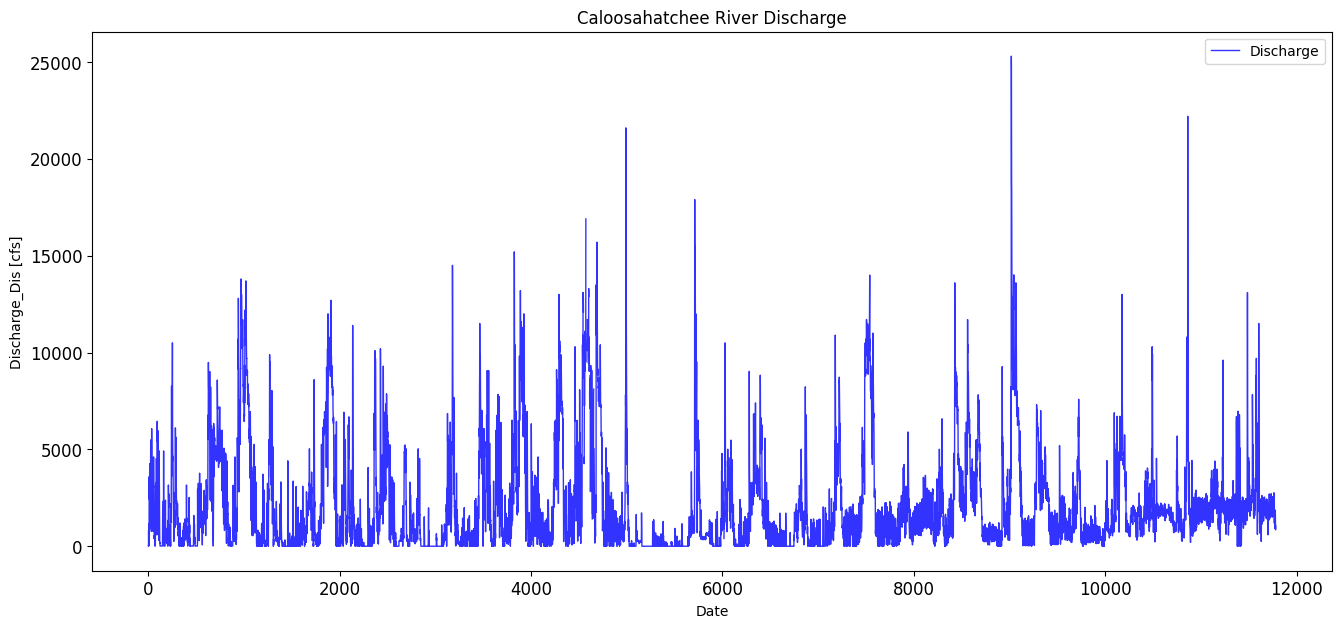

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Line plot of discharge
df_dis[['Discharge']].plot(
    color=['blue'],
    linewidth=1,
    xlabel='Date',
    ylabel='Discharge_Dis [cfs]',
    figsize=(16, 7),
    title='Caloosahatchee River Discharge',
    grid=False,
    legend=True,
    style=['-'],
    alpha=0.8,
    rot=0,
    fontsize=12,
);

In [17]:
max_discharge_dis = df_dis['Discharge'].max()
print(max_discharge_dis)


25300.0


In [18]:
avg_discharge_dis = df_dis['Discharge'].mean()
print(avg_discharge_dis)

2104.5010027425437


### 1.3 Creating a Continuous Discharge Record 

This section addresses gaps in the Caloosahatchee River discharge dataset by applying interpolation and filling techniques. Missing discharge values are first replaced with NaNs, then interpolated linearly to estimate intermediate values. Any remaining missing values at the start or end of the series are filled using forward and backward fill methods. The cleaned and gap-filled dataset is then visualized in a time series plot spanning from 1993 to 2025, showing the long-term variability in daily discharge rates. This step ensures a continuous discharge record for use in later modeling and analysis.

In [19]:
# Replace 0s with NaN in 'Discharge' column
df_dis.loc[:, 'Discharge'] = df_dis['Discharge'].replace(0, pd.NA)

# Interpolate missing values linearly
df_dis.loc[:, 'Discharge'] = df_dis['Discharge'].interpolate(method='linear')

# Fill remaining NaNs at the start/end using forward/backward fill
df_dis.loc[:, 'Discharge'] = df_dis['Discharge'].ffill().bfill()

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2941276119.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14.0 160.0 820.0 ... 1050.0 849.0 1050.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_dis.loc[:, 'Discharge'] = df_dis['Discharge'].replace(0, pd.NA)
C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2941276119.py:5: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_dis.loc[:, 'Discharge'] = df_dis['Discharge'].interpolate(method='linear')
C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2941276119.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_si

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\3424127788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dis['Date'] = pd.to_datetime(df_dis['Date'])


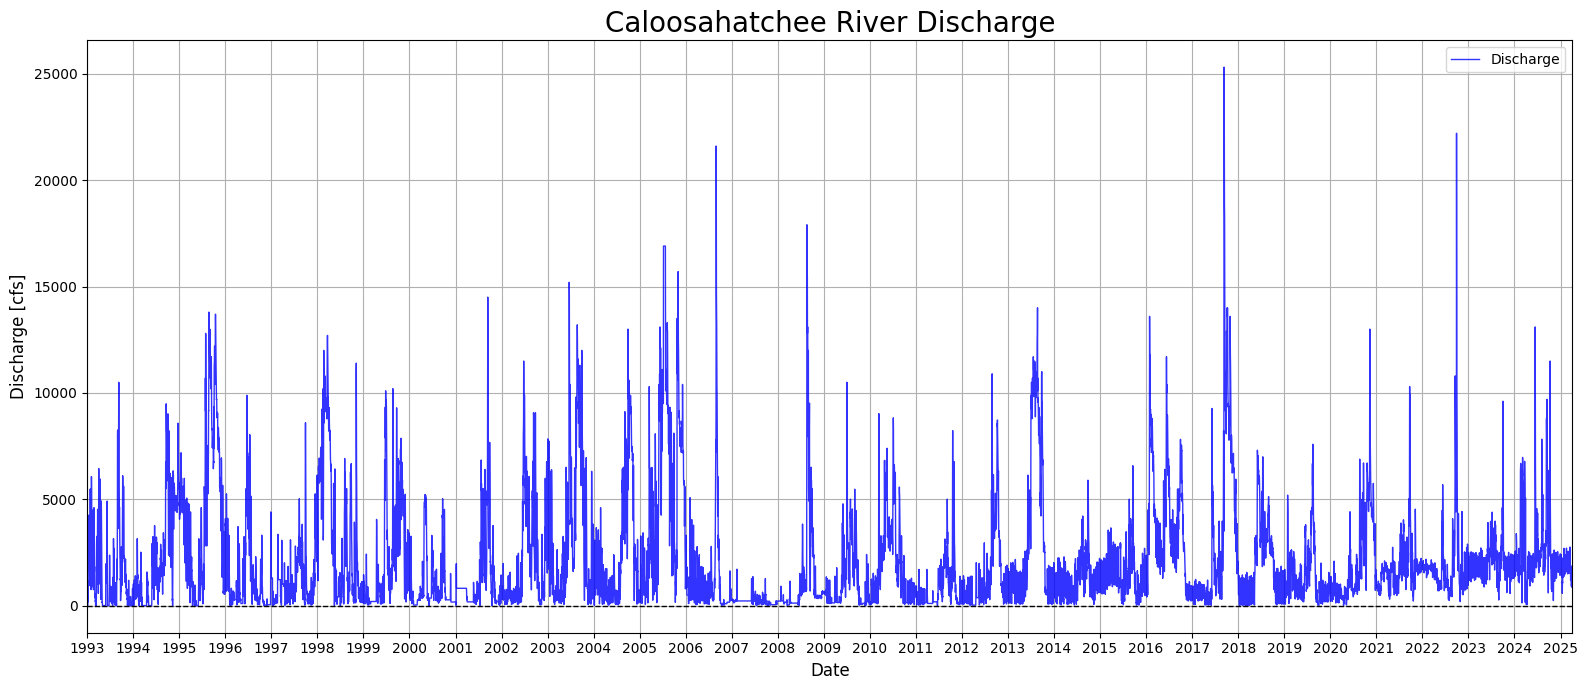

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'Date' is datetime
df_dis['Date'] = pd.to_datetime(df_dis['Date'])

# Create plot
plt.figure(num=18, figsize=(16, 7))
plt.plot(df_dis['Date'], df_dis['Discharge'], color='blue', linewidth=1, linestyle='-', alpha=0.8, label='Discharge')

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(df_dis['Date'].min(), df_dis['Date'].max())

# Add horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge [cfs]', fontsize=12)
plt.title('Caloosahatchee River Discharge', fontsize=20)
plt.legend()
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 1.4 Discharge With Hurricane Season Noted

This section enhances the Caloosahatchee River discharge time series by visually marking the Atlantic hurricane season (June 1 to November 30) for each year in the dataset. Using a loop, shaded bands are dynamically added to the plot for every hurricane season between 1993 and 2025. This contextual overlay allows for a clearer visual association between periods of heightened tropical activity and observed discharge spikes. By highlighting these seasonal windows, the plot provides insight into how discharge patterns may be influenced by rainfall and runoff associated with hurricanes and tropical storms, which are relevant for nutrient loading and potential HAB triggers.

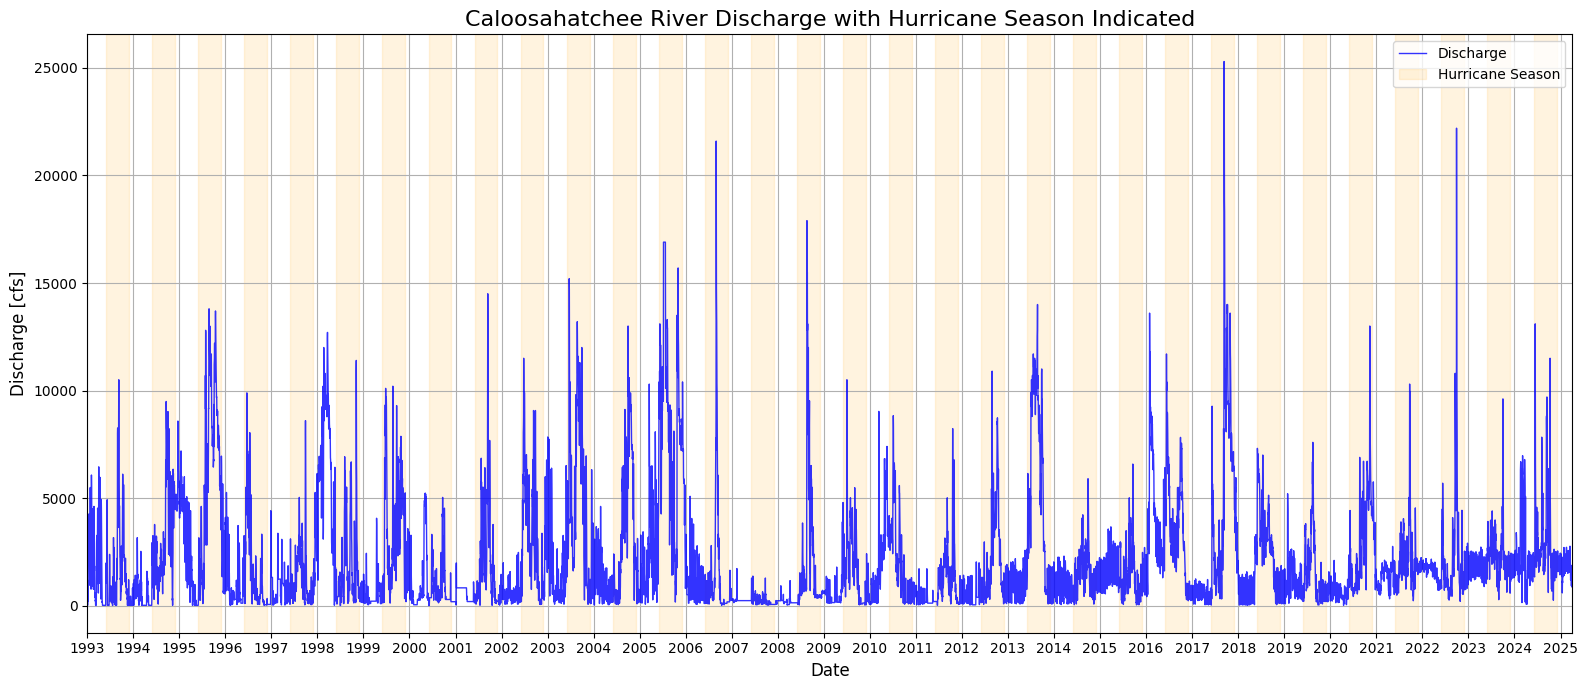

In [21]:
from datetime import datetime

plt.figure(num=19, figsize=(16, 7))
plt.plot(df_dis['Date'], df_dis['Discharge'], color='blue', linewidth=1, linestyle='-', alpha=0.8, label='Discharge')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(df_dis['Date'].min(), df_dis['Date'].max())

# Highlight hurricane season
years = df_dis['Date'].dt.year.unique()
for year in years:
    start = pd.Timestamp(f"{year}-06-01")
    end = pd.Timestamp(f"{year}-11-30")
    plt.axvspan(start, end, color='orange', alpha=0.125, label='Hurricane Season' if year == years[0] else "")

plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge [cfs]', fontsize=12)
plt.title('Caloosahatchee River Discharge with Hurricane Season Indicated', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


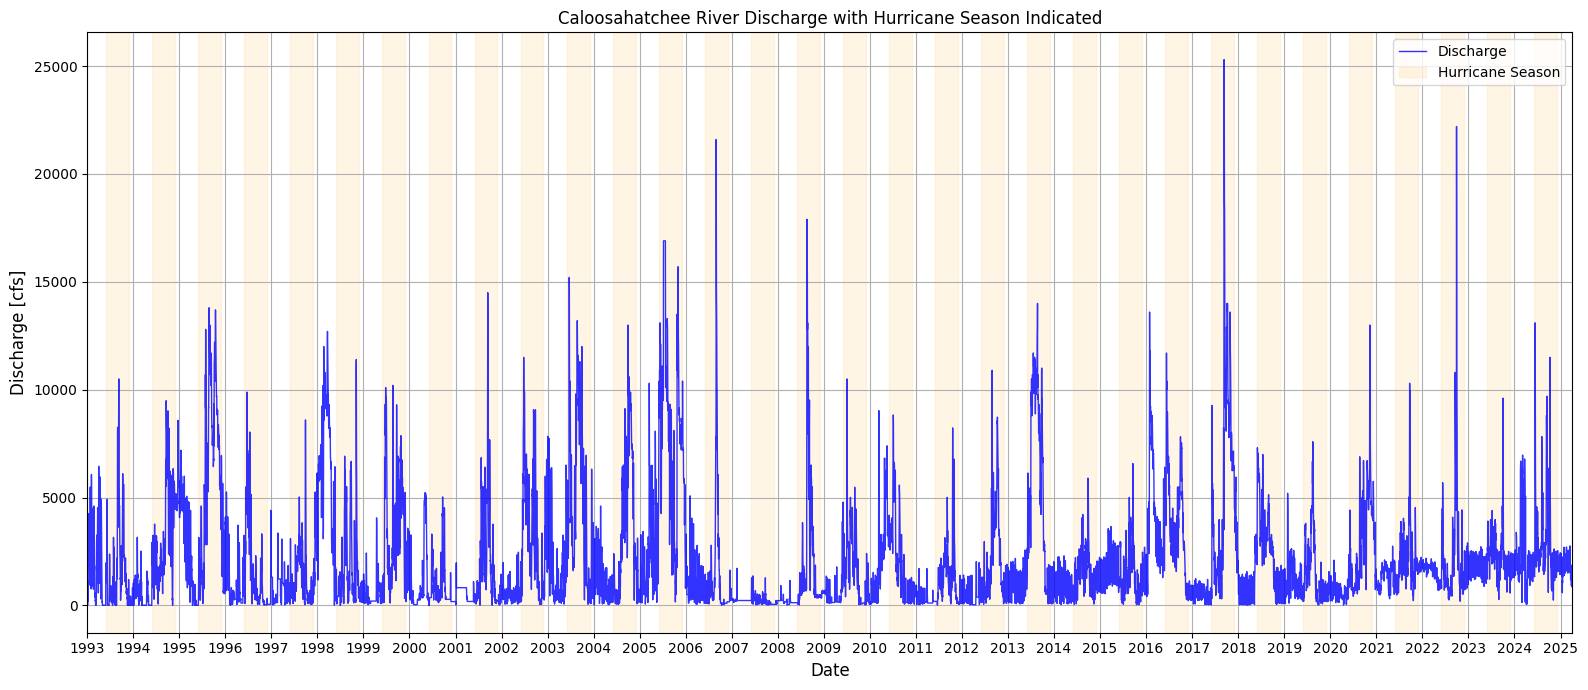

In [22]:
plt.figure(num=20, figsize=(16, 7))
plt.plot(df_dis['Date'], df_dis['Discharge'], color='blue', linewidth=1, linestyle='-', alpha=0.8, label='Discharge')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(df_dis['Date'].min(), df_dis['Date'].max())

# Shade hurricane season for each year
for year in df_dis['Date'].dt.year.unique():
    start = pd.Timestamp(f"{year}-06-01")
    end = pd.Timestamp(f"{year}-11-30")
    plt.axvspan(start, end, color='orange', alpha=0.1, label='Hurricane Season' if year == df_dis['Date'].dt.year.unique()[0] else "")

plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge [cfs]', fontsize=12)
plt.title('Caloosahatchee River Discharge with Hurricane Season Indicated', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 1.5 Correlation Between Hurricane Season and Discharge

A correlation analysis was performed to examine the relationship between river discharge and hurricane season (defined as June through November). The results show a positive correlation coefficient of 0.28, indicating that discharge tends to increase modestly during hurricane season. While not a strong correlation, this suggests that seasonal patterns—likely influenced by increased rainfall and storm activity—play a role in elevating freshwater flow in the Caloosahatchee River. This trend may contribute to nutrient loading and estuarine changes that influence red tide dynamics downstream.

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\1329633671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dis['Date'] = pd.to_datetime(df_dis['Date'])


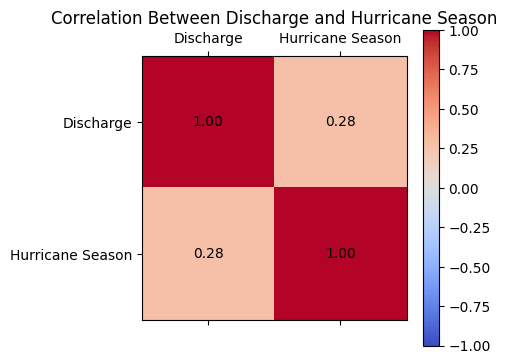

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime
df_dis['Date'] = pd.to_datetime(df_dis['Date'])

# Create Hurricane Season indicator
df_dis['Month'] = df_dis['Date'].dt.month
df_dis['Hurricane_Season'] = df_dis['Month'].between(6, 11).astype(int)

# Calculate correlation matrix
corr = df_dis[['Discharge', 'Hurricane_Season']].corr()

# Plot correlation matrix manually
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
fig.colorbar(cax)

# Tick labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Discharge', 'Hurricane Season'])
ax.set_yticklabels(['Discharge', 'Hurricane Season'])

# Annotate correlation values
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Between Discharge and Hurricane Season')
plt.tight_layout()
plt.show()


In [30]:
# This installs seaborn; skip if it's already installed
!pip install seaborn

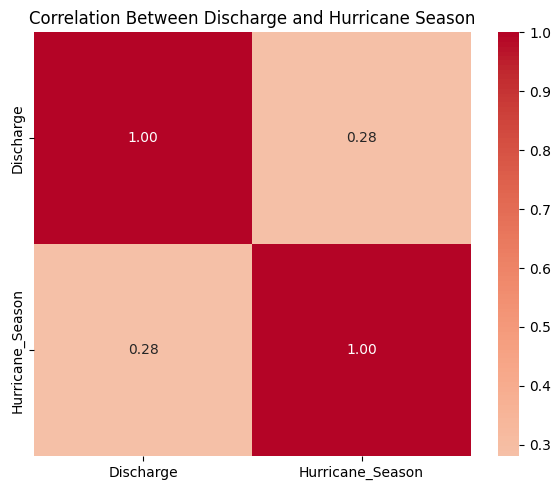

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure datetime
df_dis['Date'] = pd.to_datetime(df_dis['Date'])

# Create a hurricane season flag
df_dis['Month'] = df_dis['Date'].dt.month
df_dis['Hurricane_Season'] = df_dis['Month'].between(6, 11).astype(int)

# Correlation matrix
corr = df_dis[['Discharge', 'Hurricane_Season']].corr()

# Plot the heatmap
plt.figure(num=23, figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Between Discharge and Hurricane Season')
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

# Ensure datetime
df_dis['Date'] = pd.to_datetime(df_dis['Date'])

# Add year, month, and hurricane season flag
df_dis['Year'] = df_dis['Date'].dt.year
df_dis['Month'] = df_dis['Date'].dt.month
df_dis['Hurricane_Season'] = df_dis['Month'].between(6, 11).astype(int)

# Get peak discharge for each year
peak_discharge = df_dis.loc[df_dis.groupby('Year')['Discharge'].idxmax()].copy()

# Flag whether the peak occurred during hurricane season
peak_discharge['Peak_During_Hurricane_Season'] = peak_discharge['Hurricane_Season']

# Prepare and rename for summary
peak_discharge_summary = peak_discharge[['Year', 'Date', 'Discharge', 'Peak_During_Hurricane_Season']]
peak_discharge_summary.rename(columns={'Peak_During_Hurricane_Season': 'Peak in Hurricane Season'}, inplace=True)

# Display
print("Peak Discharge by Year:")
print(peak_discharge_summary)


Peak Discharge by Year:
       Year       Date Discharge  Peak in Hurricane Season
251    1993 1993-09-09   10500.0                         1
627    1994 1994-09-20    9490.0                         1
967    1995 1995-08-26   13800.0                         1
1267   1996 1996-06-21    9890.0                         1
1732   1997 1997-09-29    8600.0                         1
1906   1998 1998-03-22   12700.0                         0
2425   1999 1999-08-23   10200.0                         1
2682   2000 2000-05-06    5230.0                         0
3178   2001 2001-09-14   14500.0                         1
3463   2002 2002-06-26   11500.0                         1
3824   2003 2003-06-22   15200.0                         1
4291   2004 2004-10-01   13000.0                         1
4572   2005 2005-07-09   16900.0                         1
4990   2006 2006-08-31   21600.0                         1
5154   2007 2007-02-11    1720.0                         0
5710   2008 2008-08-20   17900.0

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\3431508624.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_discharge_summary.rename(columns={'Peak_During_Hurricane_Season': 'Peak in Hurricane Season'}, inplace=True)


## 2. Nutrient Data for the Caloosahatchee River: TN and TP Monitoring

The Total Nitrogen (TN) and Total Phosphorus (TP) data for both the upper and lower Caloosahatchee River were obtained from Florida's STORET repository, a state-managed version of the EPA's national water quality database. These records include monitoring results from agencies like the Florida Department of Environmental Protection and Lee County's Environmental Laboratory. 

The dataset provides time-stamped, geolocated measurements of nutrient concentrations, which are essential for assessing eutrophication risk and forecasting red tide conditions driven by land-based nutrient runoff.

Water Atlas data site: https://chnep.wateratlas.usf.edu/ 

### 2.1 Nutrient Data: Upper Caloosahatchee (Olga, FL)

This section loads nutrient monitoring data from the upper Caloosahatchee River at the S.R. 79 (Olga) station and prepares it for analysis. The dataset is filtered to extract relevant nutrient parameters and converted to datetime format for alignment with other variables.

In [26]:
import pandas as pd

# Load the Caloosahatchee nutrient data
nutrient_data = pd.read_csv("TN_TP_Caloosa.csv")

# Preview the dataset
nutrient_data.head()

,WBodyID,WaterBodyName,DataSource,StationID,StationName,Actual_StationID,Actual_Latitude,Actual_Longitude,DEP_WBID,SampleDate,...,DepthUnits,Parameter,Characteristic,Sample_Fraction,Result_Value,Result_Unit,QACode,Result_Comment,Original_Result_Value,Original_Result_Unit
0,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.7212,-81.693248,3235A,4/29/1999 0:00,...,m,TP_mgl,Phosphorus as P,Total,0.096,mg/l,NaN,NaN,0.096,mg/l
1,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.7212,-81.693248,3235A,4/29/1999 0:00,...,m,TP_mgl,Phosphorus as P,Total,0.099,mg/l,NaN,NaN,0.099,mg/l
2,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.7212,-81.693248,3235A,4/29/1999 0:00,...,m,TN_mgl,Nitrogen,NaN,1.498,mg/l,NaN,Water Institute Calculated,NaN,NaN
3,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.7212,-81.693248,3235A,5/24/1999 0:00,...,m,TP_mgl,Phosphorus as P,Total,0.170,mg/l,JQ,**JQ** The precision was outside the QC limit....,0.170,mg/l
4,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.7212,-81.693248,3235A,5/24/1999 0:00,...,m,TN_mgl,Nitrogen,NaN,1.600,mg/l,NaN,Water Institute Calculated,NaN,NaN


In [27]:
# Convert sample date to datetime
nutrient_data['SampleDate'] = pd.to_datetime(nutrient_data['SampleDate'], errors='coerce')

# Filter by nutrient type for Upper Caloosahatchee
tp_data_upper = nutrient_data[nutrient_data['Parameter'] == 'TP_mg/l']
tn_data_upper = nutrient_data[nutrient_data['Parameter'] == 'TN_mg/l']

nutrient_data

,WBodyID,WaterBodyName,DataSource,StationID,StationName,Actual_StationID,Actual_Latitude,Actual_Longitude,DEP_WBID,SampleDate,...,DepthUnits,Parameter,Characteristic,Sample_Fraction,Result_Value,Result_Unit,QACode,Result_Comment,Original_Result_Value,Original_Result_Unit
0,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.721200,-81.693248,3235A,1999-04-29,...,m,TP_mgl,Phosphorus as P,Total,0.096,mg/l,NaN,NaN,0.096,mg/l
1,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.721200,-81.693248,3235A,1999-04-29,...,m,TP_mgl,Phosphorus as P,Total,0.099,mg/l,NaN,NaN,0.099,mg/l
2,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.721200,-81.693248,3235A,1999-04-29,...,m,TN_mgl,Nitrogen,NaN,1.498,mg/l,NaN,Water Institute Calculated,NaN,NaN
3,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.721200,-81.693248,3235A,1999-05-24,...,m,TP_mgl,Phosphorus as P,Total,0.170,mg/l,JQ,**JQ** The precision was outside the QC limit....,0.170,mg/l
4,300081,Caloosahatchee River,STORET_21FLGW,3568,CALOOSAHATCHEE RIVER AT S.R. 79 NEAR OLGA,3568,26.721200,-81.693248,3235A,1999-05-24,...,m,TN_mgl,Nitrogen,NaN,1.600,mg/l,NaN,Water Institute Calculated,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,300081,Caloosahatchee River,WIN_21FLSFWM,18245,S79,18245,26.722735,-81.691019,3235A,2025-01-06,...,m,TP_mgl,Phosphorus as P,Total,0.111,mg/l,NaN,NaN,0.111,mg/L
1744,300081,Caloosahatchee River,WIN_21FLSFWM,18245,S79,18245,26.722735,-81.691019,3235A,2025-01-06,...,m,TN_mgl,Nitrogen,Dissolved,1.100,mg/l,NaN,NaN,1.100,mg/L
1745,300081,Caloosahatchee River,WIN_21FLSFWM,18245,S79,18245,26.722735,-81.691019,3235A,2025-01-06,...,m,TN_mgl,Nitrogen,Total,1.260,mg/l,NaN,NaN,1.260,mg/L
1746,300081,Caloosahatchee River,WIN_21FLSFWM,18245,S79,18245,26.722735,-81.691019,3235A,2025-01-13,...,m,TP_mgl,Phosphorus as P,Total,0.096,mg/l,NaN,NaN,0.096,mg/L


### 2.2 Total Phosphorous Over Time (Outliers Removed)

This section filters and visualizes TP data at the Olga station, removing outliers using the interquartile range (IQR) method. After converting values to numeric format and dropping any missing entries, the code calculates the lower and upper bounds for acceptable values and filters out extreme outliers. The cleaned data is then plotted as a time series.

The resulting chart shows TP concentrations over time from approximately 1999 to 2024. The data appears sparse before 2015 but becomes more densely sampled in recent years. Most values cluster between 0.05 and 0.15 mg/L, with a slight downward trend and reduced variability over time—possibly reflecting changes in land use, management practices, or sampling consistency.

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\4080073539.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_data_upper['Result_Value'] = pd.to_numeric(tp_data_upper['Result_Value'], errors='coerce')


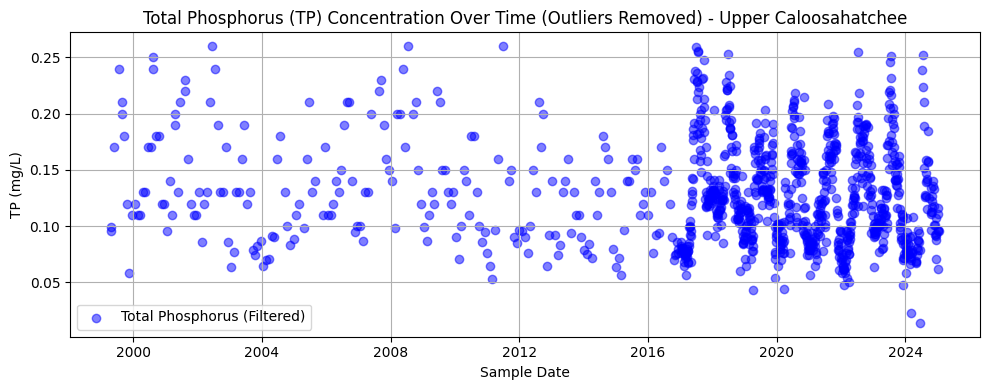

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Nutrient Data (Upper Caloosahatchee - Olga, FL) ---
nutrient_data = pd.read_csv("TN_TP_Caloosa.csv")  # or your local path
nutrient_data['SampleDate'] = pd.to_datetime(nutrient_data['SampleDate'], errors='coerce')

# Filter by correct nutrient labels (check spelling)
tp_data_upper = nutrient_data[nutrient_data['Parameter'] == 'TP_mgl']
tn_data_upper = nutrient_data[nutrient_data['Parameter'] == 'TN_mgl']

# --- 2. Clean and Filter TP Data ---
tp_data_upper['Result_Value'] = pd.to_numeric(tp_data_upper['Result_Value'], errors='coerce')
tp_clean_upper = tp_data_upper.dropna(subset=['Result_Value'])

# Detect and filter out outliers using IQR
Q1_tp = tp_clean_upper['Result_Value'].quantile(0.25)
Q3_tp = tp_clean_upper['Result_Value'].quantile(0.75)
IQR_tp = Q3_tp - Q1_tp

tp_filtered_upper = tp_clean_upper[
    (tp_clean_upper['Result_Value'] >= Q1_tp - 1.5 * IQR_tp) &
    (tp_clean_upper['Result_Value'] <= Q3_tp + 1.5 * IQR_tp)
]

# --- 3. Plot Filtered TP Data ---
plt.figure(figsize=(10, 4))
plt.scatter(tp_filtered_upper['SampleDate'], tp_filtered_upper['Result_Value'],
            alpha=0.5, color='blue', label='Total Phosphorus (Filtered)')
plt.title('Total Phosphorus (TP) Concentration Over Time (Outliers Removed) - Upper Caloosahatchee')
plt.xlabel('Sample Date')
plt.ylabel('TP (mg/L)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 2.3 Total Nitrogen Over Time (Outliers Removed)

This section processes TN data at the Olga station by converting result values to numeric format, dropping missing entries, and removing statistical outliers using the interquartile range (IQR) method. The filtered dataset is then plotted to visualize trends over time.

The resulting chart displays TN concentrations from the late 1990s through 2024. Like the phosphorus dataset, early records are sparse, with sampling density increasing significantly after 2015. Most values range between 1.0 and 1.6 mg/L. There is no obvious long-term trend, but a tighter clustering of values in more recent years may reflect improved monitoring consistency or reduced variability in nutrient inputs.

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\468480445.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_data_upper['Result_Value'] = pd.to_numeric(tn_data_upper['Result_Value'], errors='coerce')


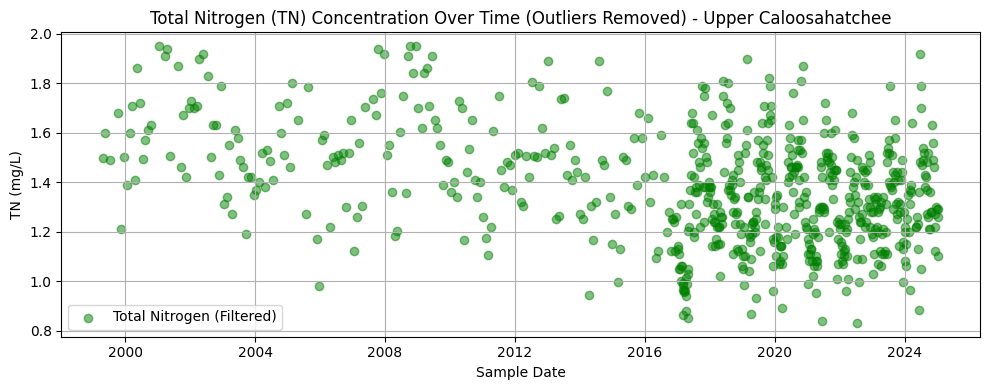

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Convert TN values to float
tn_data_upper['Result_Value'] = pd.to_numeric(tn_data_upper['Result_Value'], errors='coerce')

# Remove NaNs
tn_clean_upper = tn_data_upper.dropna(subset=['Result_Value'])

# Detect outliers using IQR
Q1 = tn_clean_upper['Result_Value'].quantile(0.25)
Q3 = tn_clean_upper['Result_Value'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
tn_filtered_upper = tn_clean_upper[
    (tn_clean_upper['Result_Value'] >= Q1 - 1.5 * IQR) &
    (tn_clean_upper['Result_Value'] <= Q3 + 1.5 * IQR)
]

# Plot filtered TN data
plt.figure(figsize=(10, 4))
plt.scatter(tn_filtered_upper['SampleDate'], tn_filtered_upper['Result_Value'],
            alpha=0.5, color='green', label='Total Nitrogen (Filtered)')
plt.title('Total Nitrogen (TN) Concentration Over Time (Outliers Removed) - Upper Caloosahatchee')
plt.xlabel('Sample Date')
plt.ylabel('TN (mg/L)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 2.4 Combined TN and TP Trendline, Olga, FL (Outliers Removed)

This section aggregates the cleaned nutrient data into monthly averages to reveal long-term trends in nitrogen and phosphorus concentrations at the Olga monitoring site. Missing months are interpolated to produce continuous time series for both parameters. The data is visualized in two synchronized subplots sharing the same time axis.

The top plot shows a monthly trend of TN concentrations, which fluctuate but show a general decline in variability and magnitude over the past two decades. The bottom plot illustrates the TP trend, which is more seasonally variable and features sharper peaks, especially in the mid-2000s and late 2010s. Together, these plots highlight nutrient dynamics over time and provide context for understanding their potential role in fueling algal blooms downstream.

In [31]:
# Resample monthly and interpolate missing months
tn_monthly_upper = tn_filtered_upper.set_index('SampleDate')['Result_Value'].resample('M').mean().asfreq('M').interpolate()
tp_monthly_upper = tp_filtered_upper.set_index('SampleDate')['Result_Value'].resample('M').mean().asfreq('M').interpolate()

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2975870262.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tn_monthly_upper = tn_filtered_upper.set_index('SampleDate')['Result_Value'].resample('M').mean().asfreq('M').interpolate()
C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2975870262.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tp_monthly_upper = tp_filtered_upper.set_index('SampleDate')['Result_Value'].resample('M').mean().asfreq('M').interpolate()


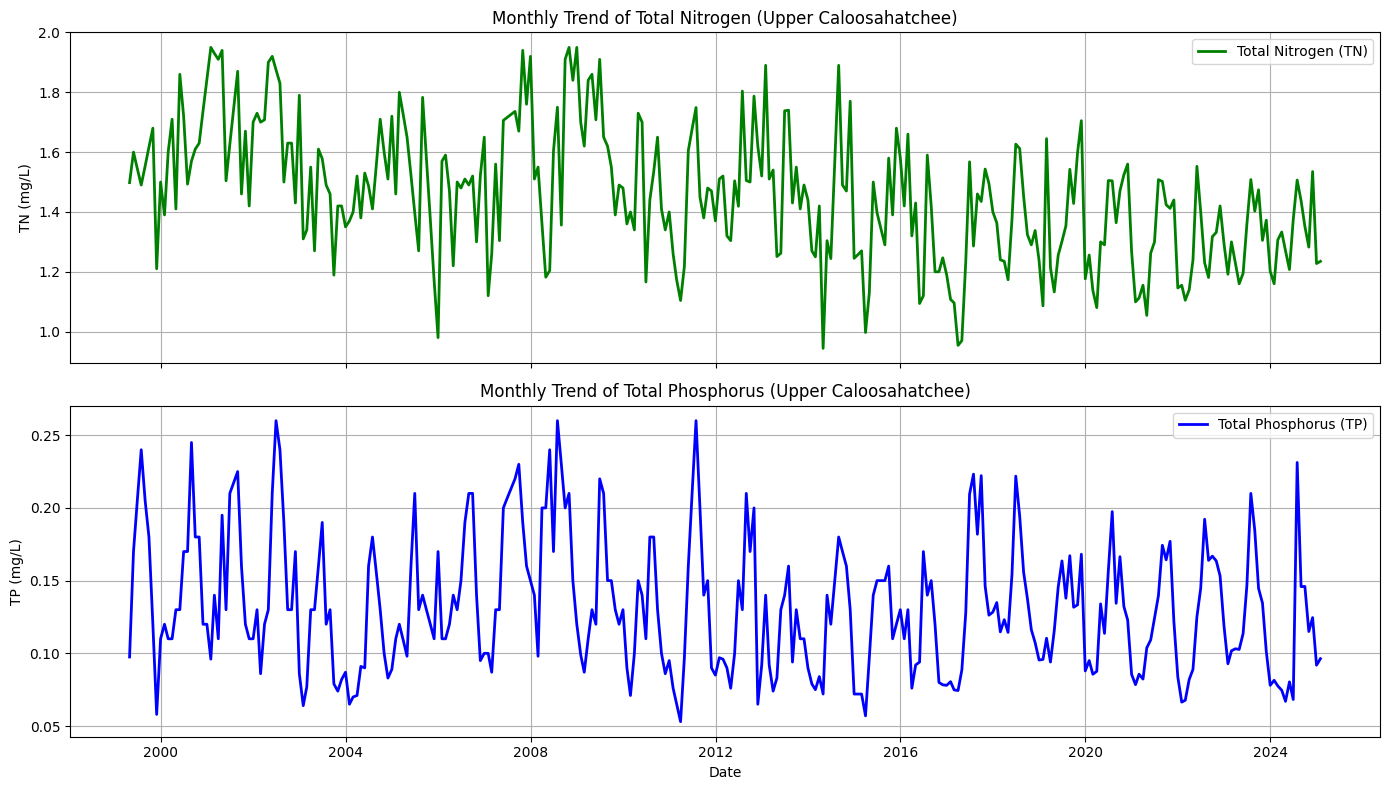

In [32]:
import matplotlib.pyplot as plt

# Plot TN and TP on two subplots (shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot TN
ax1.plot(tn_monthly_upper.index, tn_monthly_upper.values, color='green', label='Total Nitrogen (TN)', linewidth=2)
ax1.set_ylabel('TN (mg/L)')
ax1.set_title('Monthly Trend of Total Nitrogen (Upper Caloosahatchee)')
ax1.grid(True)
ax1.legend()

# Plot TP
ax2.plot(tp_monthly_upper.index, tp_monthly_upper.values, color='blue', label='Total Phosphorus (TP)', linewidth=2)
ax2.set_ylabel('TP (mg/L)')
ax2.set_title('Monthly Trend of Total Phosphorus (Upper Caloosahatchee)')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### 2.5 Nutrient Data: Lower Caloosahatchee (Fort Myers, FL)

This section loads nutrient monitoring data for the tidal portion of the Caloosahatchee River near Fort Myers. As with the upper river data, this dataset includes TN and TP measurements and is used to complement the upstream records. Including this site allows the analysis to capture nutrient movement downstream, offering a fuller picture of how concentrations evolve as water flows from the Olga station toward the Gulf of America.

In [33]:
import pandas as pd

# Load the Caloosahatchee nutrient data
nutrient_tidal = pd.read_csv("TN_TP_Tidal_Caloosa.csv")

# Preview the dataset
nutrient_tidal.head()

,WBodyID,WaterBodyName,DataSource,StationID,StationName,Actual_StationID,Actual_Latitude,Actual_Longitude,DEP_WBID,SampleDate,...,DepthUnits,Parameter,Characteristic,Sample_Fraction,Result_Value,Result_Unit,QACode,Result_Comment,Original_Result_Value,Original_Result_Unit
0,9000108,Lower Tidal Caloosahatchee River,STORET_21FLEECO,DEEPGR10,DEEP LAGOON- McGregor Blvd.,DEEPGR10,26.53932,-81.9188,3240A,10/16/1990 0:00,...,m,TP_mgl,Phosphorus as P,Total,0.16,mg/l,NaN,NaN,0.16,mg/l
1,9000108,Lower Tidal Caloosahatchee River,STORET_21FLEECO,DEEPGR10,DEEP LAGOON- McGregor Blvd.,DEEPGR10,26.53932,-81.9188,3240A,10/16/1990 0:00,...,m,TN_mgl,Nitrogen,Total,1.27,mg/l,NaN,Water Institute Calculated: TKN + NOx,NaN,NaN
2,9000108,Lower Tidal Caloosahatchee River,STORET_21FLEECO,DEEPGR10,DEEP LAGOON- McGregor Blvd.,DEEPGR10,26.53932,-81.9188,3240A,10/31/1990 0:00,...,m,TN_mgl,Nitrogen,Total,4.77,mg/l,NaN,Water Institute Calculated: TKN + NOx,NaN,NaN
3,9000108,Lower Tidal Caloosahatchee River,STORET_21FLEECO,DEEPGR10,DEEP LAGOON- McGregor Blvd.,DEEPGR10,26.53932,-81.9188,3240A,10/31/1990 0:00,...,m,TP_mgl,Phosphorus as P,Total,0.10,mg/l,NaN,NaN,0.10,mg/l
4,9000108,Lower Tidal Caloosahatchee River,STORET_21FLEECO,DEEPGR10,DEEP LAGOON- McGregor Blvd.,DEEPGR10,26.53932,-81.9188,3240A,11/19/1990 0:00,...,m,TP_mgl,Phosphorus as P,Total,0.11,mg/l,NaN,NaN,0.11,mg/l


### 2.6 Total Phosphorous Over Time (Outliers Removed)

This section repeats the methods of Section 2.2 for the tidal Caloosahatchee River. 

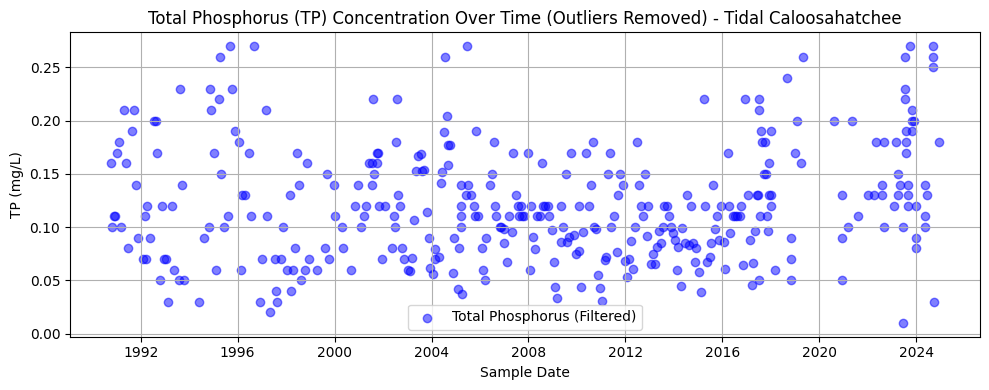

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Strip any trailing/leading whitespace from column names
nutrient_tidal.columns = nutrient_tidal.columns.str.strip()

# --- Convert TP values to numeric ---
tp_data_tidal = nutrient_tidal[nutrient_tidal['Parameter'] == 'TP_mgl'].copy()
tp_data_tidal['Result_Value'] = pd.to_numeric(tp_data_tidal['Result_Value'], errors='coerce')
tp_data_tidal['SampleDate'] = pd.to_datetime(tp_data_tidal['SampleDate'], errors='coerce')

# --- Remove NaNs ---
tp_clean_tidal = tp_data_tidal.dropna(subset=['Result_Value'])

# --- Detect outliers using IQR ---
Q1_tp = tp_clean_tidal['Result_Value'].quantile(0.25)
Q3_tp = tp_clean_tidal['Result_Value'].quantile(0.75)
IQR_tp = Q3_tp - Q1_tp

# --- Filter out outliers ---
tp_filtered_tidal = tp_clean_tidal[
    (tp_clean_tidal['Result_Value'] >= Q1_tp - 1.5 * IQR_tp) &
    (tp_clean_tidal['Result_Value'] <= Q3_tp + 1.5 * IQR_tp)
]

# --- Plot Filtered TP data ---
plt.figure(figsize=(10, 4))
plt.scatter(tp_filtered_tidal['SampleDate'], tp_filtered_tidal['Result_Value'], 
            alpha=0.5, color='blue', label='Total Phosphorus (Filtered)')
plt.title('Total Phosphorus (TP) Concentration Over Time (Outliers Removed) - Tidal Caloosahatchee')
plt.xlabel('Sample Date')
plt.ylabel('TP (mg/L)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 2.7 Total Nitrogen Over Time (Outliers Removed)

This section repeats the methods of Section 2.3 for the tidal Caloosahatchee River. 

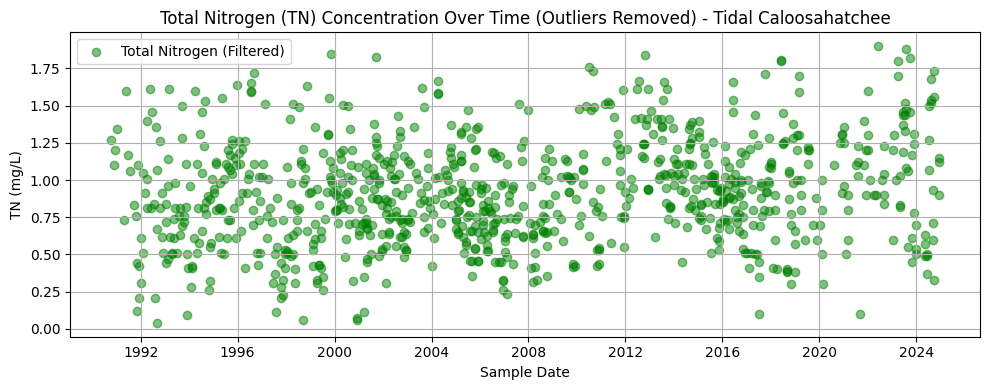

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Filter and convert TN values
tn_data_tidal = nutrient_tidal[nutrient_tidal['Parameter'] == 'TN_mgl'].copy()
tn_data_tidal['Result_Value'] = pd.to_numeric(tn_data_tidal['Result_Value'], errors='coerce')
tn_data_tidal['SampleDate'] = pd.to_datetime(tn_data_tidal['SampleDate'], errors='coerce')

# Remove NaNs
tn_clean_tidal = tn_data_tidal.dropna(subset=['Result_Value'])

# Detect outliers using IQR
Q1_tn_tidal = tn_clean_tidal['Result_Value'].quantile(0.25)
Q3_tn_tidal = tn_clean_tidal['Result_Value'].quantile(0.75)
IQR_tn_tidal = Q3_tn_tidal - Q1_tn_tidal

# Filter out outliers
tn_filtered_tidal = tn_clean_tidal[
    (tn_clean_tidal['Result_Value'] >= Q1_tn_tidal - 1.5 * IQR_tn_tidal) &
    (tn_clean_tidal['Result_Value'] <= Q3_tn_tidal + 1.5 * IQR_tn_tidal)
]

# Plot Filtered TN data
plt.figure(figsize=(10, 4))
plt.scatter(tn_filtered_tidal['SampleDate'], tn_filtered_tidal['Result_Value'], 
            alpha=0.5, color='green', label='Total Nitrogen (Filtered)')
plt.title('Total Nitrogen (TN) Concentration Over Time (Outliers Removed) - Tidal Caloosahatchee')
plt.xlabel('Sample Date')
plt.ylabel('TN (mg/L)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 2.8 Combined TN and TP Trendline, Fort Myers (Outliers Removed)

This section repeats the methods of Section 2.4 for the tidal Caloosahatchee River. 

In [36]:
# --- Resample monthly and interpolate missing months for Tidal Caloosahatchee ---
tn_monthly_tidal = tn_filtered_tidal.set_index('SampleDate')['Result_Value'] \
    .resample('M').mean().asfreq('M').interpolate()

tp_monthly_tidal = tp_filtered_tidal.set_index('SampleDate')['Result_Value'] \
    .resample('M').mean().asfreq('M').interpolate()

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\4036337590.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().asfreq('M').interpolate()
C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\4036337590.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().asfreq('M').interpolate()


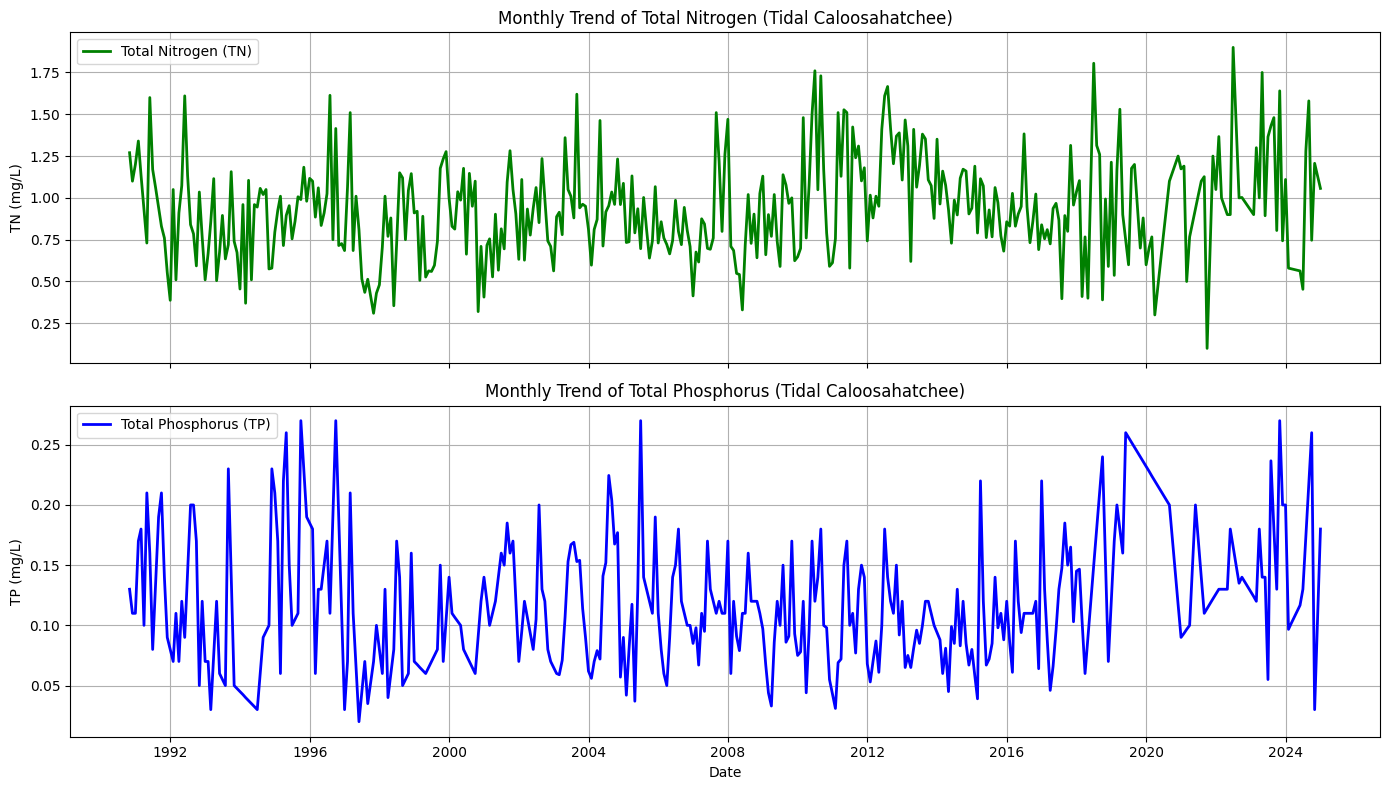

In [37]:
import matplotlib.pyplot as plt

# --- Plot TN and TP trends for Tidal Caloosahatchee in stacked subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# TN plot
ax1.plot(tn_monthly_tidal.index, tn_monthly_tidal.values, color='green', linewidth=2, label='Total Nitrogen (TN)')
ax1.set_ylabel('TN (mg/L)')
ax1.set_title('Monthly Trend of Total Nitrogen (Tidal Caloosahatchee)')
ax1.grid(True)
ax1.legend()

# TP plot
ax2.plot(tp_monthly_tidal.index, tp_monthly_tidal.values, color='blue', linewidth=2, label='Total Phosphorus (TP)')
ax2.set_ylabel('TP (mg/L)')
ax2.set_title('Monthly Trend of Total Phosphorus (Tidal Caloosahatchee)')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### 2.9 Combined and Averaged Time Series for the Caloosahatchee River

To better support the machine learning analysis, we combined the TN and TP data from both the upper (Olga) and lower (Fort Myers) Caloosahatchee River sites. 

This was done by averaging the monthly resampled and interpolated TN and TP concentrations from both locations. The result is a single, unified timeseries for TN and TP that represents the average nutrient concentrations flowing out of the Caloosahatchee River. 

This provides a more comprehensive and simplified input for evaluating how nutrient levels may correlate with harmful algal bloom (HAB) activity in downstream coastal waters.

In [38]:
# --- Combine and average monthly TN and TP data from upper and tidal Caloosahatchee ---

# First align the date indices to ensure no mismatch
tn_monthly_upper = tn_monthly_upper.sort_index()
tp_monthly_upper = tp_monthly_upper.sort_index()
tn_monthly_tidal = tn_monthly_tidal.sort_index()
tp_monthly_tidal = tp_monthly_tidal.sort_index()

# Align on same monthly date index (outer join, then take average where both exist)
combined_tn = pd.concat([tn_monthly_upper, tn_monthly_tidal], axis=1)
combined_tp = pd.concat([tp_monthly_upper, tp_monthly_tidal], axis=1)

# Rename columns for clarity
combined_tn.columns = ['TN_Upper', 'TN_Tidal']
combined_tp.columns = ['TP_Upper', 'TP_Tidal']

# Take the average (will ignore NaN if one side is missing)
combined_tn['TN_Avg'] = combined_tn.mean(axis=1)
combined_tp['TP_Avg'] = combined_tp.mean(axis=1)

# Extract final single-column Series for modeling
tn_avg = combined_tn['TN_Avg']
tp_avg = combined_tp['TP_Avg']


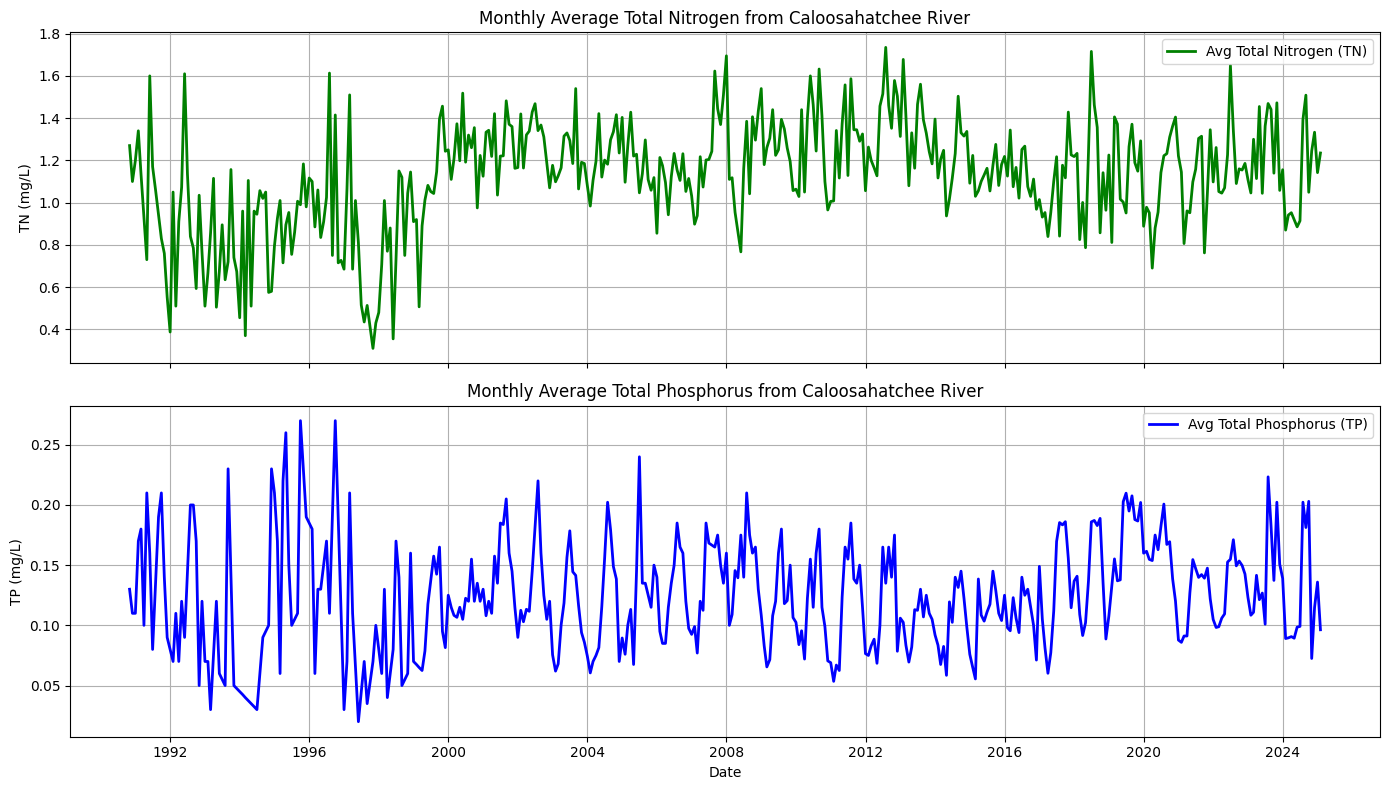

In [39]:
import matplotlib.pyplot as plt

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot TN
ax1.plot(tn_avg.index, tn_avg.values, color='green', linewidth=2, label='Avg Total Nitrogen (TN)')
ax1.set_ylabel('TN (mg/L)')
ax1.set_title('Monthly Average Total Nitrogen from Caloosahatchee River')
ax1.grid(True)
ax1.legend()

# Plot TP
ax2.plot(tp_avg.index, tp_avg.values, color='blue', linewidth=2, label='Avg Total Phosphorus (TP)')
ax2.set_ylabel('TP (mg/L)')
ax2.set_title('Monthly Average Total Phosphorus from Caloosahatchee River')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Sea Suface Temperature Data

The sea surface temperature (SST) data used in this analysis is derived from satellite-based NetCDF datasets, which provide detailed, gridded observations of ocean surface conditions. 

These datasets are accessed using the xarray library and combined to create a continuous timeline of temperature patterns in the Gulf region. SST is a critical variable for predicting red tide blooms, as elevated temperatures can enhance the growth and persistence of harmful algal species like Karenia brevis. 

By monitoring SST trends, researchers can identify periods of thermal conditions that are favorable for red tide development and spread, improving early warning systems and environmental response efforts.

Copernicus site data: https://data.marine.copernicus.eu/products You will need to create a Copernicus account to gain access. 

In [40]:
import xarray as xr

# Exact file paths from your Downloads folder
file_list = [
    "C:/Users/mkduu/Downloads/cmems_mod_glo_phy_my_0.083deg_P1D-m_thetao_82.83W-81.75W_25.92N-27.08N_0.49-9.57m_1993-01-01-2021-06-30.nc",
    "C:/Users/mkduu/Downloads/cmems_mod_glo_phy_myint_0.083deg_P1D-m_thetao_82.83W-81.75W_25.92N-27.08N_0.49-9.57m_2021-07-01-2025-02-25.nc"
]

# Load and combine
ds_combined = xr.open_mfdataset(file_list, combine="by_coords")

# Preview the dataset structure
display(ds_combined)


<xarray.Dataset> Size: 158MB
Dimensions:    (time: 11744, depth: 8, latitude: 15, longitude: 14)
Coordinates:
  * depth      (depth) float32 32B 0.494 1.541 2.646 3.819 ... 6.441 7.93 9.573
  * latitude   (latitude) float32 60B 25.92 26.0 26.08 ... 26.92 27.0 27.08
  * longitude  (longitude) float32 56B -82.83 -82.75 -82.67 ... -81.83 -81.75
  * time       (time) datetime64[ns] 94kB 1993-01-01 1993-01-02 ... 2025-02-25
Data variables:
    thetao     (time, depth, latitude, longitude) float64 158MB dask.array<chunksize=(10408, 8, 15, 14), meta=np.ndarray>
Attributes:
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    comment:                   CMEMS product
    Conventions:               CF-1.4
    references:                http://www.mercator-ocean.fr
    institution:               MERCATOR OCEAN
    title:                     daily mean fields from Global Ocean Physics An...
    source:                    MERCATOR GLORYS12V1
    copernicusmarine_version:  2.0.1

### 3.1 Mean Ocean Temperature by Depth and Time

This section visualizes the average ocean temperature (thetao) across all latitudes and longitudes in the dataset, plotted over time and depth. The result is a heatmap showing how temperature varies vertically in the water column from 1993 to 2025. The plot reveals stable stratification patterns, with relatively little variation in mean temperature at different depths when spatially averaged. This provides a baseline understanding of thermal structure in the region.

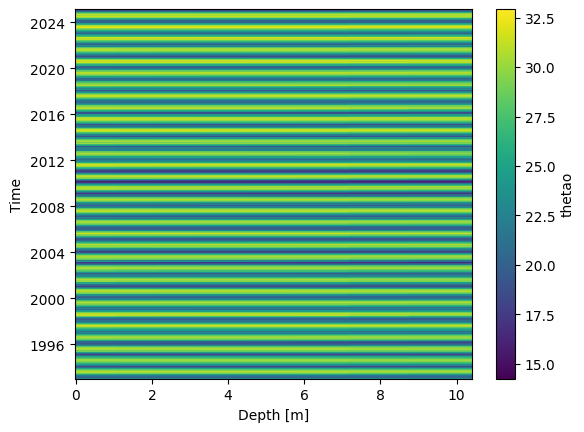

In [41]:
mean_sst = ds_combined.thetao.mean(dim=('latitude', 'longitude')).plot()

### 3.2 Regional Sea Surface Temperature Time Series (~0.5 m Depth)

This section extracts SST values at approximately 0.5 meters depth and averages them across the study region to generate a daily time series from 1993 to 2025. The resulting plot shows strong seasonal temperature fluctuations, with peaks in summer and troughs in winter, typically ranging between 15°C and 32.5°C. These cycles reflect regional climate patterns and can play a key role in red tide dynamics, as elevated SSTs are often associated with increased HAB activity. This time series serves as a foundational variable for assessing thermal influence on bloom development.

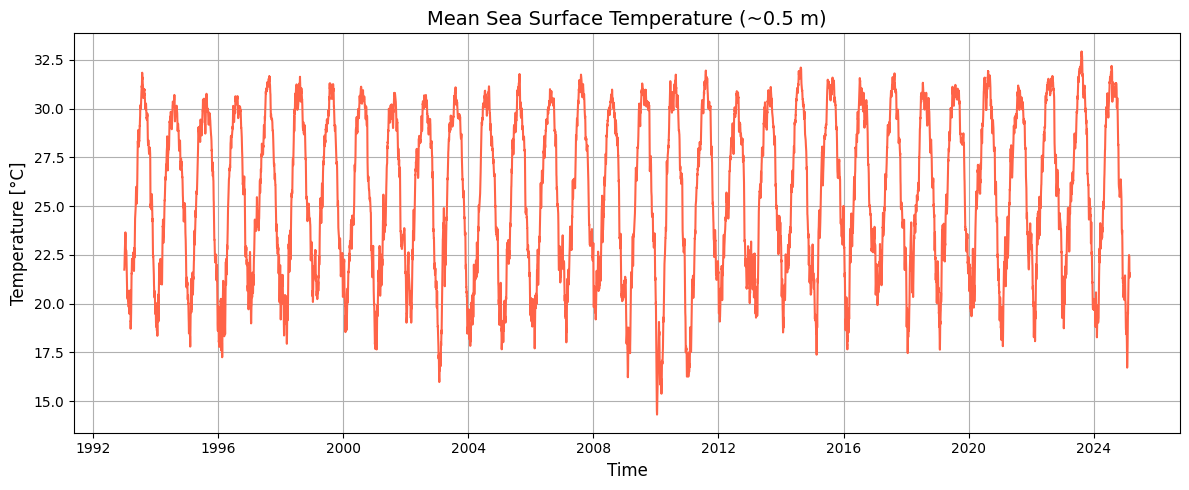

In [42]:
import matplotlib.pyplot as plt

# 1. Select the shallowest available depth using nearest match
surface_sst = ds_combined.thetao.sel(depth=0.5, method='nearest')

# 2. Average across lat/lon to get region-wide SST
mean_surface_sst = surface_sst.mean(dim=['latitude', 'longitude'])

# 3. Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(mean_surface_sst['time'], mean_surface_sst, color='tomato')
plt.title("Mean Sea Surface Temperature (~0.5 m)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Temperature [°C]", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Wind Direction and Speed, and Precipitation Data

The wind direction and speed data in this analysis was sourced from the NOAA weather station at Fort Myers Page Field Airport. It includes daily records of wind direction (WDF5), peak wind speed (WSF5), and precipitation (PRCP), which were cleaned, converted, and analyzed using Python. 

Wind plays a critical role in the transport and surface movement of harmful algal blooms like red tide. Sustained onshore winds can push surface blooms toward the coast, increasing exposure risks for marine life and coastal communities.

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns

# --- 1. Load and Clean Data ---
file_path = '3988701.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Keep only relevant columns
df_peak = df[['DATE', 'WDF5', 'WSF5', 'PRCP']].copy()
df_peak = df_peak.dropna(subset=['WDF5', 'WSF5', 'PRCP'])

# Convert data types
df_peak['DATE'] = pd.to_datetime(df_peak['DATE'])
df_peak['WDF5'] = pd.to_numeric(df_peak['WDF5'], errors='coerce')
df_peak['WSF5'] = pd.to_numeric(df_peak['WSF5'], errors='coerce')
df_peak['PRCP'] = pd.to_numeric(df_peak['PRCP'], errors='coerce')

# --- 2. Transform Data ---
# Wind speed in mph
df_peak['WSF5_mph'] = df_peak['WSF5'] * 2.23694

# Wind direction to compass
def deg_to_compass(deg):
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    ix = int((deg + 22.5) % 360 // 45)
    return dirs[ix]

df_peak['Wind_Compass'] = df_peak['WDF5'].apply(deg_to_compass)
df_peak['Year'] = df_peak['DATE'].dt.year
df_peak = df_peak.sort_values('DATE')

### 4.1 3D Wind Direction Frequency by Year

This section presents a 3D bar plot showing the annual frequency of wind observations from each compass direction between 1993 and 2025. The dataset is grouped by year and compass heading, allowing for the visualization of prevailing wind patterns over time. Understanding shifts in wind direction and intensity is important for evaluating surface water transport and the potential movement of HABs along the coastline.

Each bar represents how often wind came from a specific direction in a given year. Taller bars indicate more frequent wind from that direction. For example, consistent peaks in the NE or E directions suggest dominant wind patterns from the Gulf that could push surface waters—and potentially HABs—toward the shoreline. The visualization reveals temporal and directional trends, highlighting both long-term consistency and possible variability in wind forcing.

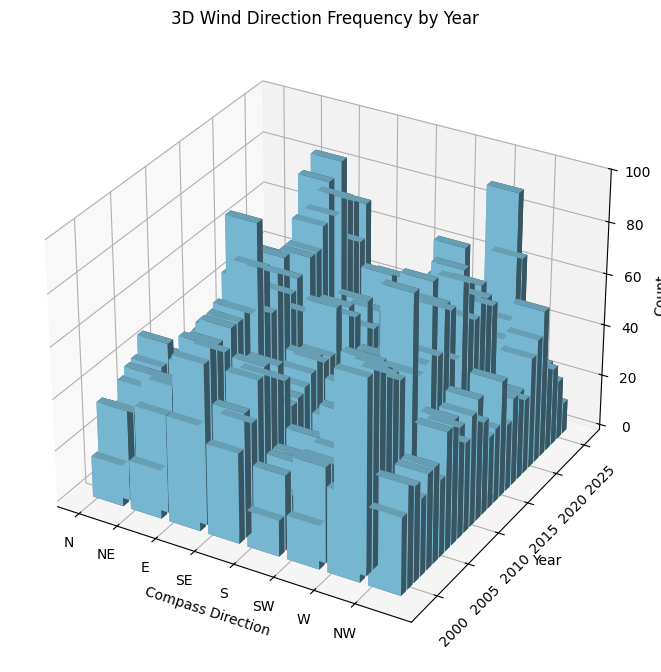

In [44]:
# --- 3. Plot 3D Wind Direction Frequency by Year ---
pivot = df_peak.pivot_table(
    index='Wind_Compass',
    columns='Year',
    values='DATE',
    aggfunc='count',
    fill_value=0
).reindex(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

directions = pivot.index.tolist()
years = pivot.columns.tolist()
dx = dy = 0.8

xpos, ypos = np.meshgrid(np.arange(len(directions)), np.arange(len(years)), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dz = pivot.values.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='skyblue')

ax.set_xlabel('Compass Direction')
ax.set_ylabel('Year')
ax.set_zlabel('Count')
ax.set_xticks(np.arange(len(directions)))
ax.set_xticklabels(directions)

# Show year ticks every 5 years
year_ticks = [year for year in years if year % 5 == 0]
tick_indices = [years.index(year) for year in year_ticks]
ax.set_yticks(tick_indices)
ax.set_yticklabels(year_ticks, rotation=45)

plt.title('3D Wind Direction Frequency by Year')
plt.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.9)
plt.show()

### 4.2 Daily Precipitation Trends with 15-Day Rolling Average

This section visualizes daily precipitation over time, with a 15-day rolling average to smooth short-term variability and highlight broader seasonal and annual trends. The dataset spans from 1998 to 2025 and helps contextualize rainfall as a driver of freshwater flow and nutrient loading into the Caloosahatchee River, which may contribute to conditions favorable for HAB development.

The chart shows high interannual variability with recurring seasonal peaks, particularly during summer and early fall—consistent with Florida's wet season and hurricane activity. This visualization helps identify when and how intense precipitation events may coincide with increased river discharge and nutrient delivery to coastal waters.

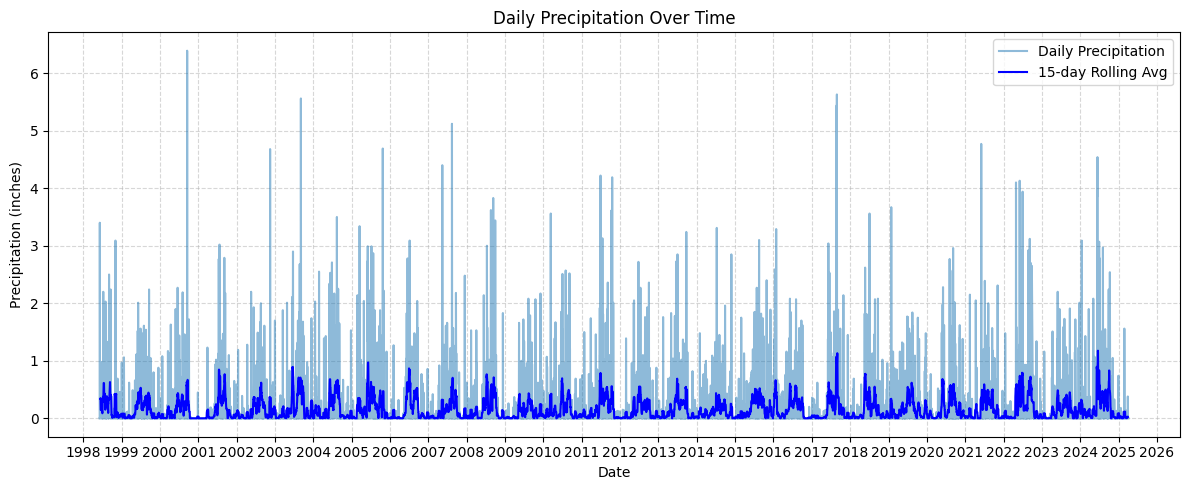

In [45]:
# --- 4. Precipitation Plot with 15-day Rolling Avg ---
plt.figure(figsize=(12, 5))
plt.plot(df_peak['DATE'], df_peak['PRCP'], label='Daily Precipitation', alpha=0.5)
plt.plot(df_peak['DATE'], df_peak['PRCP'].rolling(window=15, center=True).mean(), color='blue', label='15-day Rolling Avg')
plt.title('Daily Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.tight_layout()
plt.show()

### 4.3 Daily Peak Wind Speed with 15-Day Rolling Average

This section displays daily peak wind speed measurements from 1998 to 2025, along with a 15-day rolling average to smooth out short-term fluctuations. Monitoring wind speed trends is critical for understanding atmospheric conditions that influence ocean surface mixing and the movement of nutrient-rich runoff toward coastal waters—both of which can affect HAB formation and transport.

While peak values occasionally spike above 100 mph—likely corresponding to major storms or hurricanes—the smoothed average shows a relatively consistent baseline with periodic variation. This combination of short-term extremes and long-term patterns helps characterize the wind regime relevant to bloom development and coastal dispersal dynamics.

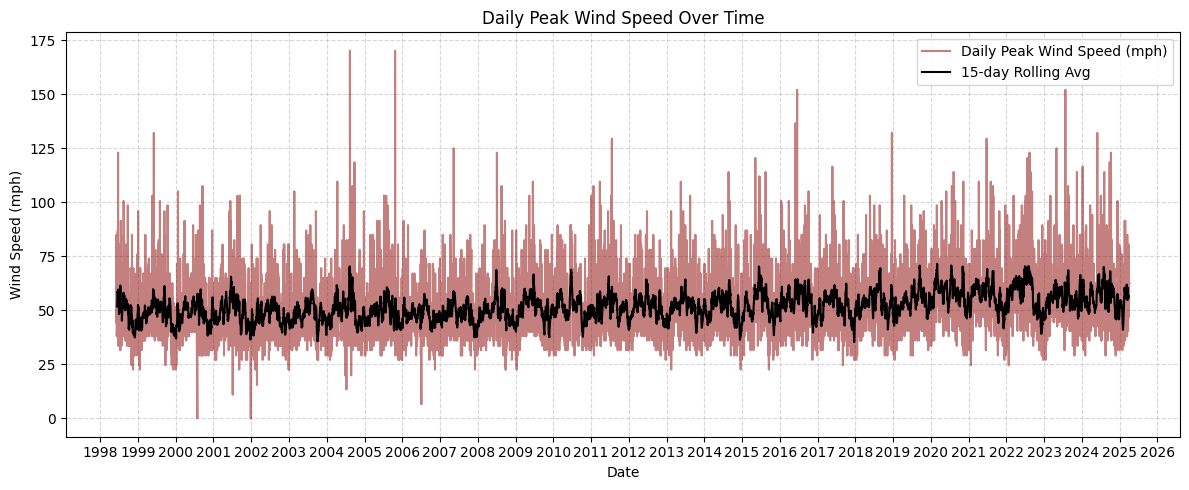

In [46]:
# --- 5. Wind Speed Plot with 15-day Rolling Avg ---
plt.figure(figsize=(12, 5))
plt.plot(df_peak['DATE'], df_peak['WSF5_mph'], label='Daily Peak Wind Speed (mph)', color='darkred', alpha=0.5)
plt.plot(df_peak['DATE'], df_peak['WSF5_mph'].rolling(window=15, center=True).mean(), color='black', label='15-day Rolling Avg')
plt.title('Daily Peak Wind Speed Over Time')
plt.xlabel('Date')
plt.ylabel('Wind Speed (mph)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.tight_layout()
plt.show()

## 5. Harmful Algal Bloom (HAB) Observation Data Cleaning and Regional Tagging

The red tide dataset used in this analysis was obtained from the Harmful Algal Bloom Observing System (HABSOS), a Gulf of America regional data system managed in coordination with NOAA. The data includes georeferenced records of Karenia brevis cell concentrations, along with environmental parameters such as salinity, water temperature, wind direction, and wind speed.

Data download: https://www.ncei.noaa.gov/archive/archive-management-system/OAS/bin/prd/jquery/accession/details/120767

In [47]:
import pandas as pd

# --- Load the HABSOS data (update path as needed) ---
hab_file = 'habsos_20240430.csv'  # or full path like '/Users/.../Downloads/habsos_20240430.csv'
hab_df = pd.read_csv(hab_file, low_memory=False)

# --- Select only useful columns ---
hab_columns = [
    'STATE_ID', 'DESCRIPTION', 'LATITUDE', 'LONGITUDE', 'SAMPLE_DATE', 'CELLCOUNT',
    'SALINITY', 'WATER_TEMP', 'WIND_DIR', 'WIND_SPEED'
]
hab_df = hab_df[hab_columns]

# --- Tag regions by lat/lon ---
hab_df['REGION'] = 'Other'

tampa_mask = (hab_df['LATITUDE'] >= 27) & (hab_df['LATITUDE'] <= 28) & (hab_df['LONGITUDE'] >= -85)
charlotte_mask = (hab_df['LATITUDE'] >= 25.5) & (hab_df['LATITUDE'] < 27) & (hab_df['LONGITUDE'] >= -85)

hab_df.loc[tampa_mask, 'REGION'] = 'Tampa Bay'
hab_df.loc[charlotte_mask, 'REGION'] = 'Charlotte Harbor'

# --- Preview the cleaned data ---
hab_df.head()


,STATE_ID,DESCRIPTION,LATITUDE,LONGITUDE,SAMPLE_DATE,CELLCOUNT,SALINITY,WATER_TEMP,WIND_DIR,WIND_SPEED,REGION
0,TX,Copano Bay 4,28.07237,-97.21968,2023/09/27,0,NaN,NaN,NaN,NaN,Other
1,TX,Copano Bay 2,27.99567,-97.16831,2023/09/27,0,NaN,NaN,NaN,NaN,Other
2,TX,Copano Bay 3,28.03930,-97.15836,2023/09/27,0,NaN,NaN,NaN,NaN,Other
3,TX,Copano Bay 1,28.06491,-97.11270,2023/09/27,0,NaN,NaN,NaN,NaN,Other
4,FL,off New Smyrna Beach; Atlantic,29.17460,-78.27890,1990/12/20,0,NaN,24.2,NaN,NaN,Other


### 5.1 Narrowing HAB Scope to Southwest Florida

This section filters the HAB dataset to focus specifically on the Charlotte Harbor region of Southwest Florida. Records are selected based on latitude and longitude boundaries that define this geographic area. The resulting subset contains over 56,000 entries and provides a concentrated dataset of bloom activity and environmental conditions relevant to the Caloosahatchee River outflow and surrounding Gulf waters. This regional focus supports more targeted analysis of local bloom dynamics.

In [48]:
charlotte_harbor_df = hab_df[
    (hab_df['LATITUDE'] >= 25.5) & (hab_df['LATITUDE'] < 27) &
    (hab_df['LONGITUDE'] >= -83) & (hab_df['LONGITUDE'] <= -81.5)
].copy()
charlotte_harbor_df

,STATE_ID,DESCRIPTION,LATITUDE,LONGITUDE,SAMPLE_DATE,CELLCOUNT,SALINITY,WATER_TEMP,WIND_DIR,WIND_SPEED,REGION
23424,FL,Ten Thousand isl; inshore,25.66670,-81.5000,1976/12/01,0,NaN,19.0,NaN,NaN,Charlotte Harbor
23425,FL,Ten Thousand isl; inshore,25.66670,-81.5000,1976/12/14,333,NaN,22.5,NaN,NaN,Charlotte Harbor
23426,FL,Rodgers River; ~15 mi off,25.50000,-81.5000,1977/11/15,0,NaN,21.5,NaN,NaN,Charlotte Harbor
23441,FL,ECOHAB Southern Rivers Cruise Station 109,25.74970,-81.5017,2003/05/18,0,NaN,NaN,NaN,NaN,Charlotte Harbor
23472,FL,Everglades National Park; offshore,25.70910,-81.5037,2006/12/12,97000,37.32,20.2,NaN,NaN,Charlotte Harbor
...,...,...,...,...,...,...,...,...,...,...,...
175904,FL,Seamap Station 26004,25.50000,-83.0000,1999/09/27,0,NaN,NaN,NaN,NaN,Charlotte Harbor
175905,FL,Seamap Station 26004,25.50000,-83.0000,2001/10/12,0,NaN,NaN,NaN,NaN,Charlotte Harbor
175906,FL,Seamap Station 26004,25.50000,-83.0000,2001/10/12,0,NaN,NaN,NaN,NaN,Charlotte Harbor
175913,FL,Charlotte Harbor; 40 mi,26.73333,-83.0000,2004/07/13,0,NaN,NaN,NaN,NaN,Charlotte Harbor


### 5.2 Long-Term Trends in Karenia brevis Concentration – Charlotte Harbor

This section refines the HAB dataset to include only Charlotte Harbor observations west of -81.5° longitude, ensuring that only Gulf-facing records are included. The data is cleaned by removing null or zero cell count values and converting dates and concentrations to numeric format. Daily mean cell concentrations are calculated, interpolated to fill temporal gaps, and smoothed using a 15-day rolling average to better visualize long-term bloom activity.

The chart spans over 70 years, revealing both the frequency and intensity of red tide blooms in the region. Notable spikes occur in several years, particularly post-1995, suggesting periods of elevated bloom severity. This visualization provides historical context for bloom behavior and serves as a foundation for identifying environmental conditions associated with high-risk periods.

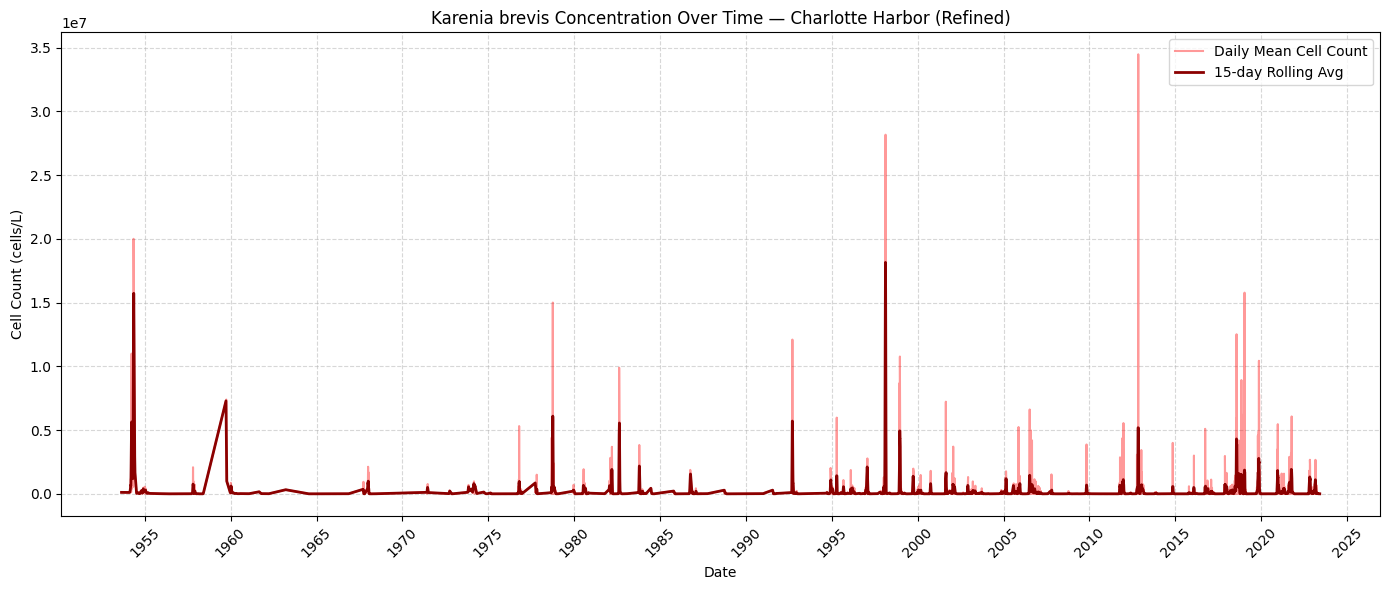

In [52]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- Refined filter for Charlotte Harbor only (SWFL, exclude Atlantic) ---
charlotte_harbor_df = hab_df[
    (hab_df['LATITUDE'] >= 25.5) & (hab_df['LATITUDE'] < 27) &
    (hab_df['LONGITUDE'] >= -83) & (hab_df['LONGITUDE'] <= -81.5)
].copy()

# --- Convert and clean ---
charlotte_harbor_df['SAMPLE_DATE'] = pd.to_datetime(charlotte_harbor_df['SAMPLE_DATE'], errors='coerce')
charlotte_harbor_df['CELLCOUNT'] = pd.to_numeric(charlotte_harbor_df['CELLCOUNT'], errors='coerce')

charlotte_harbor_df = charlotte_harbor_df.dropna(subset=['SAMPLE_DATE', 'CELLCOUNT'])
charlotte_harbor_df = charlotte_harbor_df[charlotte_harbor_df['CELLCOUNT'] > 0]

# --- Group and smooth ---
ch_daily = charlotte_harbor_df.groupby('SAMPLE_DATE')['CELLCOUNT'].mean()
ch_daily = ch_daily.resample('D').mean().interpolate()
ch_rolling = ch_daily.rolling(window=15, center=True).mean()

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(ch_daily.index, ch_daily.values, color='red', alpha=0.4, label='Daily Mean Cell Count')
plt.plot(ch_rolling.index, ch_rolling.values, color='darkred', linewidth=2, label='15-day Rolling Avg')

plt.title('Karenia brevis Concentration Over Time — Charlotte Harbor (Refined)')
plt.xlabel('Date')
plt.ylabel('Cell Count (cells/L)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Improve x-axis date formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Show ticks every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.3 Stacked Graphic for Envirnomental Indicators

This stacked graphic summarizes seven time-series indicators relevant to red tide bloom dynamics in Southwest Florida. It includes:

Karenia brevis concentrations in Charlotte Harbor

Daily precipitation and wind speed trends

Sea surface temperature (SST) at ~0.5 m depth

Monthly nutrient levels (Total Nitrogen and Total Phosphorus) in the Caloosahatchee River

Daily discharge from the Caloosahatchee River, an important vector for nutrient delivery to coastal waters.

These combined metrics help illustrate how environmental conditions shift over time and potentially contribute to bloom formation and persistence.

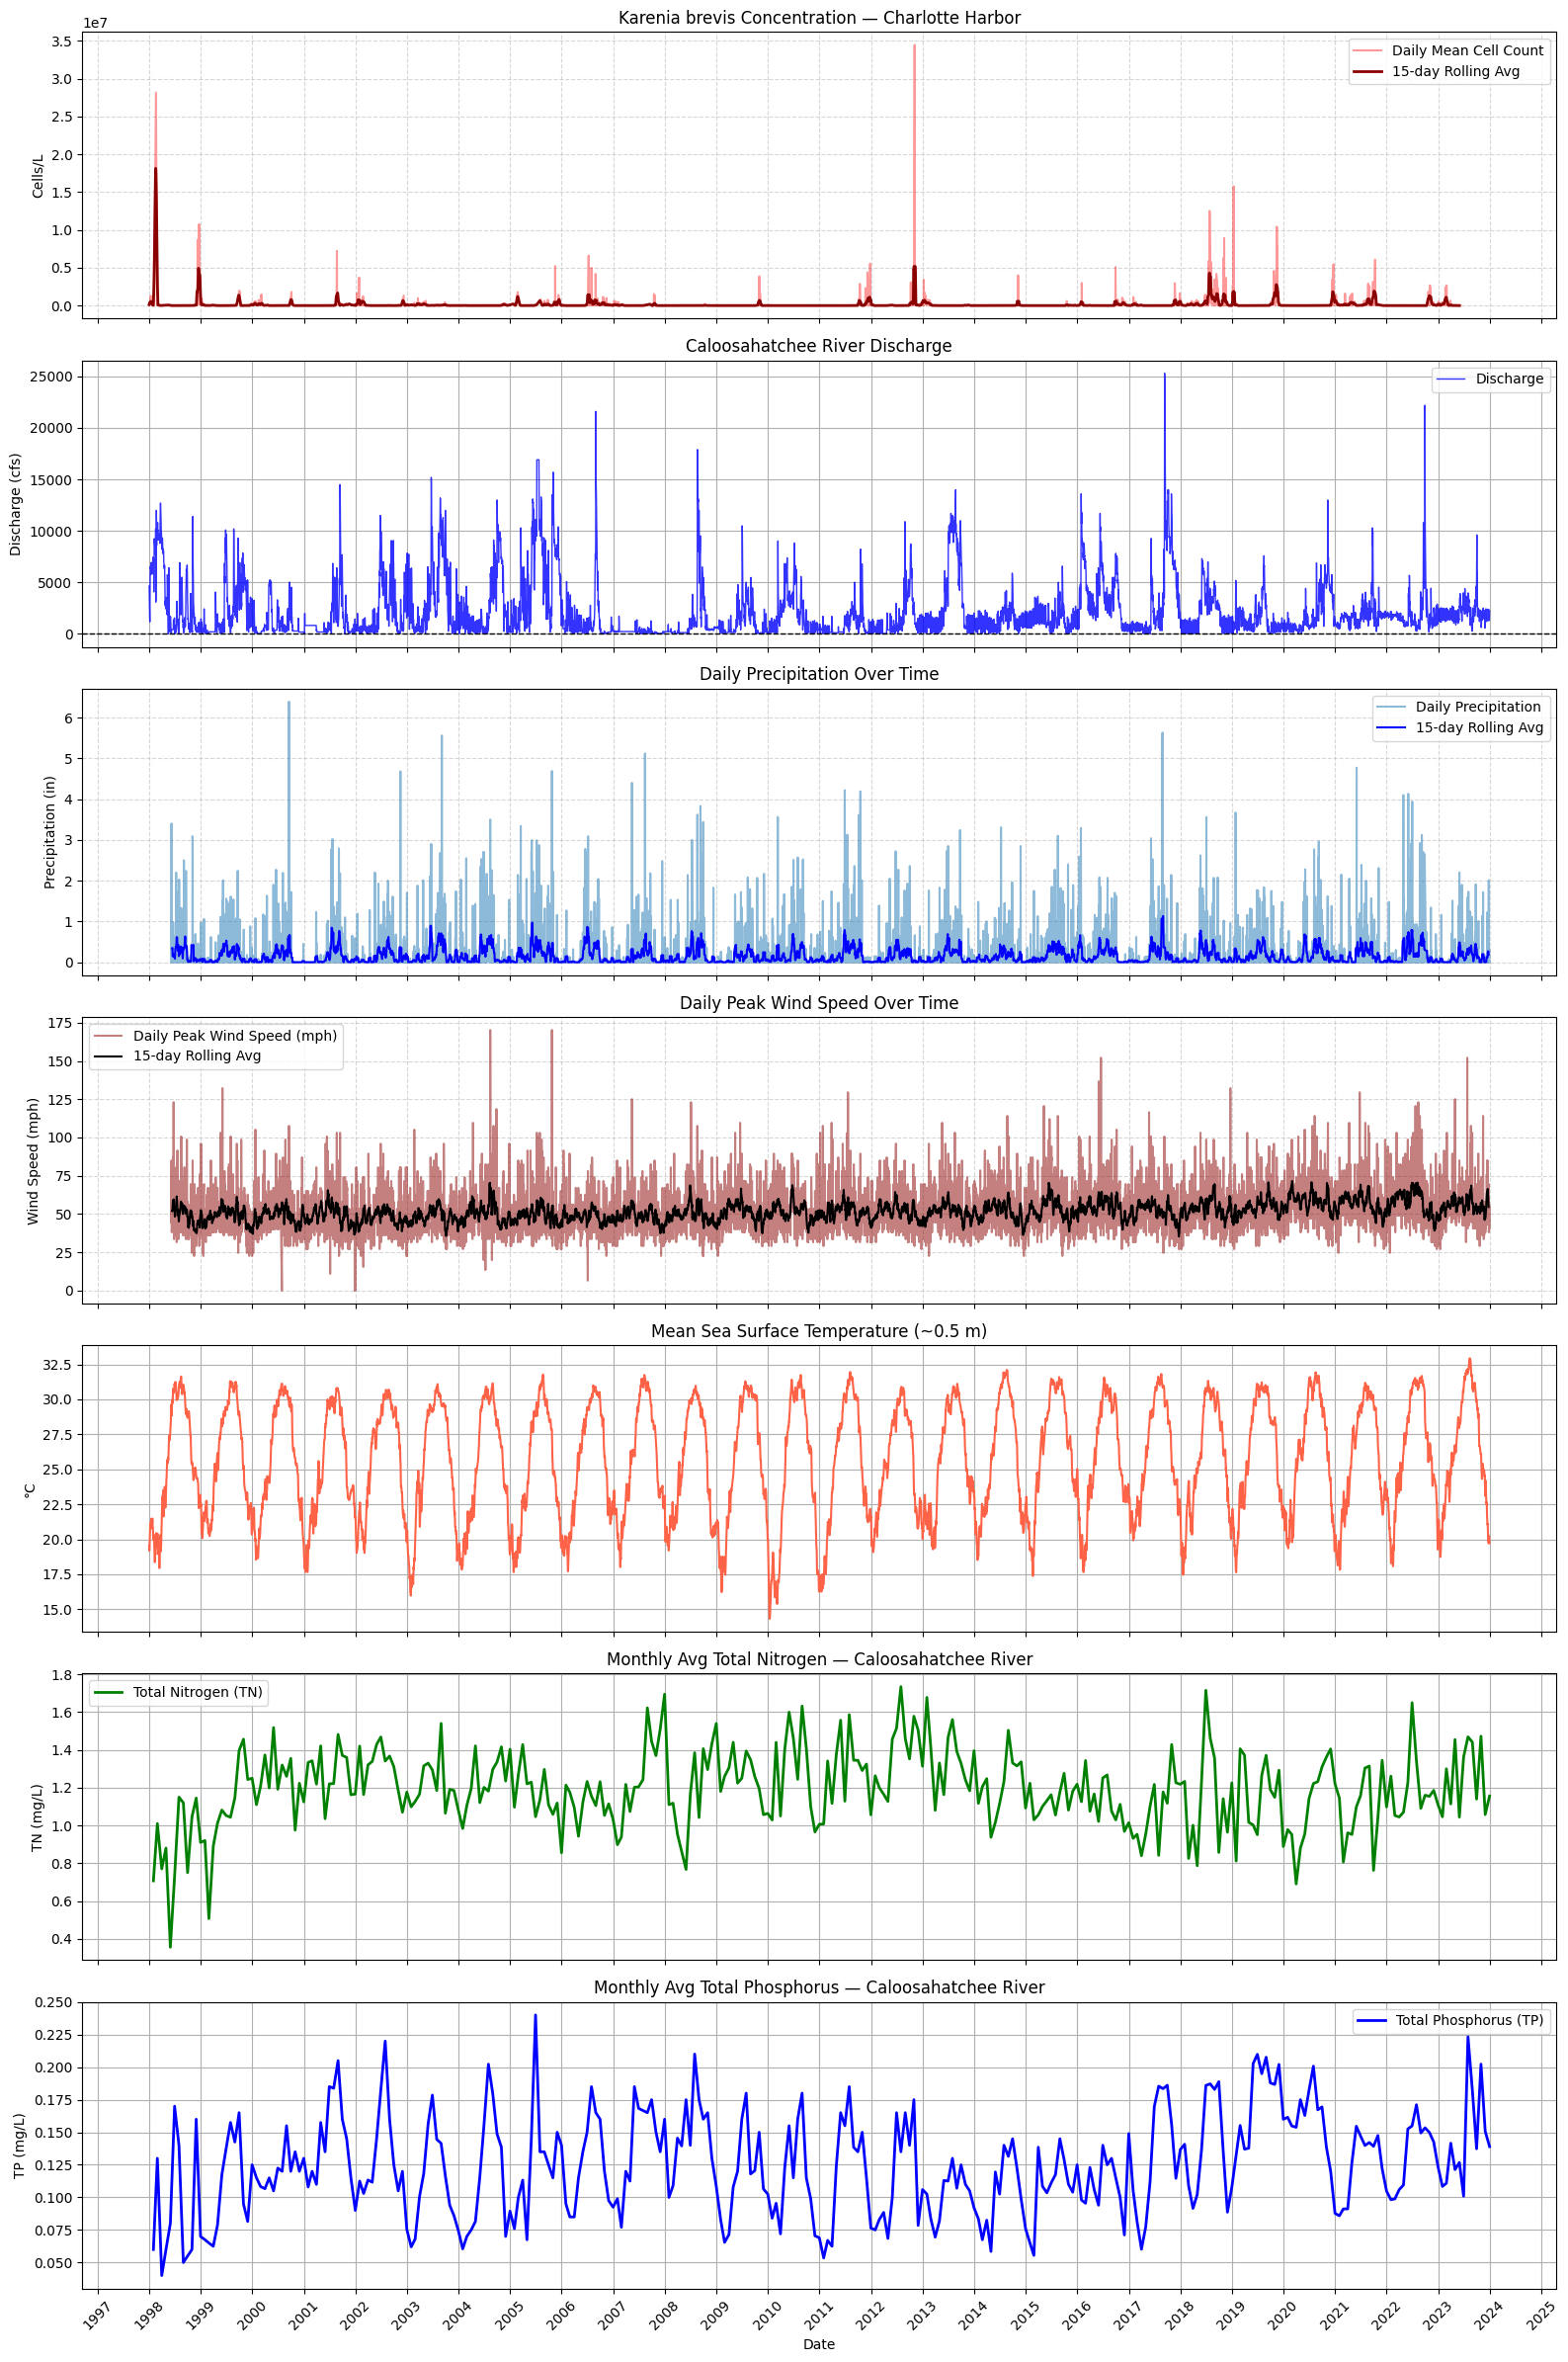

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Define date range
start_date = pd.to_datetime("1998-01-01")
end_date = pd.to_datetime("2023-12-31")

# --- Filter all datasets to 1998–2023 ---

# 1. Karenia brevis
ch_daily_filtered = ch_daily[(ch_daily.index >= start_date) & (ch_daily.index <= end_date)]
ch_rolling_filtered = ch_rolling[(ch_rolling.index >= start_date) & (ch_rolling.index <= end_date)]

# 2. Discharge
df_dis_filtered = df_dis[(df_dis['Date'] >= start_date) & (df_dis['Date'] <= end_date)]

# 3. Precipitation & Wind
df_peak_filtered = df_peak[(df_peak['DATE'] >= start_date) & (df_peak['DATE'] <= end_date)]

# 4. SST
sst_filtered = mean_surface_sst.sel(time=slice(start_date, end_date))

# 5. TN / TP
tn_avg_filtered = tn_avg[(tn_avg.index >= start_date) & (tn_avg.index <= end_date)]
tp_avg_filtered = tp_avg[(tp_avg.index >= start_date) & (tp_avg.index <= end_date)]

# --- Create Stacked Plot ---
fig, axes = plt.subplots(7, 1, figsize=(16, 24), sharex=True)

# 1. Karenia brevis
axes[0].plot(ch_daily_filtered.index, ch_daily_filtered.values, color='red', alpha=0.4, label='Daily Mean Cell Count')
axes[0].plot(ch_rolling_filtered.index, ch_rolling_filtered.values, color='darkred', linewidth=2, label='15-day Rolling Avg')
axes[0].set_ylabel('Cells/L')
axes[0].set_title('Karenia brevis Concentration — Charlotte Harbor')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# 2. Discharge
axes[1].plot(df_dis_filtered['Date'], df_dis_filtered['Discharge'], color='blue', linewidth=1, linestyle='-', alpha=0.8, label='Discharge')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_ylabel('Discharge (cfs)')
axes[1].set_title('Caloosahatchee River Discharge')
axes[1].legend()
axes[1].grid(True)

# 3. Precipitation
axes[2].plot(df_peak_filtered['DATE'], df_peak_filtered['PRCP'], label='Daily Precipitation', alpha=0.5)
axes[2].plot(df_peak_filtered['DATE'], df_peak_filtered['PRCP'].rolling(window=15, center=True).mean(), color='blue', label='15-day Rolling Avg')
axes[2].set_ylabel('Precipitation (in)')
axes[2].set_title('Daily Precipitation Over Time')
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.5)

# 4. Wind Speed
axes[3].plot(df_peak_filtered['DATE'], df_peak_filtered['WSF5_mph'], label='Daily Peak Wind Speed (mph)', color='darkred', alpha=0.5)
axes[3].plot(df_peak_filtered['DATE'], df_peak_filtered['WSF5_mph'].rolling(window=15, center=True).mean(), color='black', label='15-day Rolling Avg')
axes[3].set_ylabel('Wind Speed (mph)')
axes[3].set_title('Daily Peak Wind Speed Over Time')
axes[3].legend()
axes[3].grid(True, linestyle='--', alpha=0.5)

# 5. SST
axes[4].plot(sst_filtered['time'], sst_filtered, color='tomato')
axes[4].set_ylabel('°C')
axes[4].set_title('Mean Sea Surface Temperature (~0.5 m)')
axes[4].grid(True)

# 6. TN
axes[5].plot(tn_avg_filtered.index, tn_avg_filtered.values, color='green', linewidth=2, label='Total Nitrogen (TN)')
axes[5].set_ylabel('TN (mg/L)')
axes[5].set_title('Monthly Avg Total Nitrogen — Caloosahatchee River')
axes[5].legend()
axes[5].grid(True)

# 7. TP
axes[6].plot(tp_avg_filtered.index, tp_avg_filtered.values, color='blue', linewidth=2, label='Total Phosphorus (TP)')
axes[6].set_ylabel('TP (mg/L)')
axes[6].set_title('Monthly Avg Total Phosphorus — Caloosahatchee River')
axes[6].set_xlabel('Date')
axes[6].legend()
axes[6].grid(True)

# --- Shared x-axis formatting ---
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("stacked_plot_1998_2023.png", dpi=300)
plt.show()

## 6. Machine Learning Model

### 6.1 Random Forest Classification of Harmful Algal Bloom Risk

To explore the relationship between environmental factors and HABs, we applied a machine learning classification model using scikit-learn. Specifically, we trained a Random Forest classifier to predict whether a bloom occurred in a given month based on a combination of environmental factors: TN, TP, river discharge, wind speed, precipitation, and SST. These features were selected because they are known to influence nutrient loading, water mixing, and temperature conditions — all of which play a role in the formation and persistence of Karenia brevis blooms. The model used historical monthly averages and a binary bloom threshold of 100,000 cells/L to classify bloom conditions, and we evaluated its performance using a confusion matrix, classification report, and feature importance scores.

C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2011159656.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  discharge_monthly = df_dis.set_index('Date')['Discharge'].resample('M').mean()
C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2011159656.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wind_monthly = df_peak.set_index('DATE')['WSF5'].resample('M').mean()
C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2011159656.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  precip_monthly = df_peak.set_index('DATE')['PRCP'].resample('M').mean()
C:\Users\mkduu\AppData\Local\Temp\ipykernel_852\2011159656.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sst_monthly = sst_df.set_index('time')['thetao'].resample('M').mean()
C:\Users\mkduu\AppData\Local\Temp\ipykern

Confusion Matrix:
[[38  3]
 [22  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.93      0.75        41
           1       0.00      0.00      0.00        22

    accuracy                           0.60        63
   macro avg       0.32      0.46      0.38        63
weighted avg       0.41      0.60      0.49        63



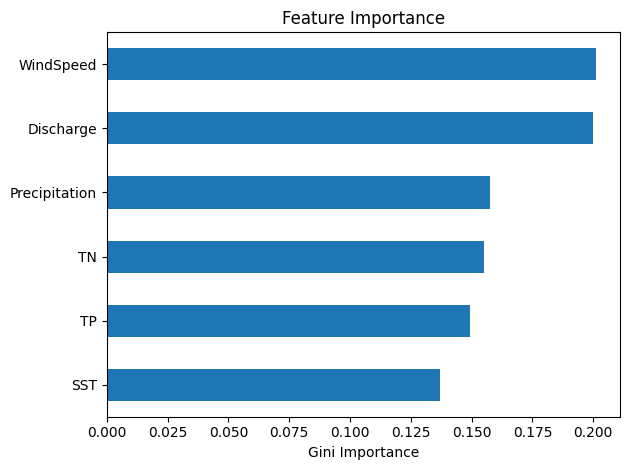

In [54]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# --- Step 1: Ensure datetime columns ---
df_dis['Date'] = pd.to_datetime(df_dis['Date'], errors='coerce')
df_peak['DATE'] = pd.to_datetime(df_peak['DATE'], errors='coerce')
charlotte_harbor_df['SAMPLE_DATE'] = pd.to_datetime(charlotte_harbor_df['SAMPLE_DATE'], errors='coerce')

# --- Step 2: Resample monthly means ---
discharge_monthly = df_dis.set_index('Date')['Discharge'].resample('M').mean()
wind_monthly = df_peak.set_index('DATE')['WSF5'].resample('M').mean()
precip_monthly = df_peak.set_index('DATE')['PRCP'].resample('M').mean()
sst_df = mean_surface_sst.to_dataframe().reset_index()
sst_monthly = sst_df.set_index('time')['thetao'].resample('M').mean()
hab_monthly = charlotte_harbor_df.set_index('SAMPLE_DATE')['CELLCOUNT'].resample('M').mean()

# --- Step 3: Combine into one DataFrame ---
combined_df = pd.concat(
    [
        tn_avg.rename('TN'),
        tp_avg.rename('TP'),
        discharge_monthly.rename('Discharge'),
        wind_monthly.rename('WindSpeed'),
        precip_monthly.rename('Precipitation'),
        sst_monthly.rename('SST'),
        hab_monthly.rename('HAB_Cells')
    ],
    axis=1
).dropna()


# --- Step 4: Create binary target variable (1 = bloom if > 100,000 cells/L) ---
combined_df['HAB_Bloom'] = (combined_df['HAB_Cells'] >= 100000).astype(int)

# --- Step 5: Train/test split ---
X = combined_df[['TN', 'TP', 'Discharge', 'WindSpeed', 'Precipitation', 'SST']]
y = combined_df['HAB_Bloom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Step 6: Train model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 7: Evaluate model ---
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature Importance
import matplotlib.pyplot as plt
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', title="Feature Importance")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()

#### Conclusion

The code properly splits the dataset into training and testing sets using the train_test_split function from scikit-learn. This ensures that the model is trained on one portion of the data and evaluated on a separate, unseen portion to provide an unbiased assessment of its predictive performance. Specifically, 75% of the data is used to train the Random Forest classifier, while the remaining 25% is set aside for testing. The random_state=42 parameter ensures the split is reproducible, meaning the same data points will consistently be assigned to the training and testing sets across runs. This type of data partitioning is a standard and essential practice in machine learning, as it helps prevent overfitting and allows for reliable model evaluation.

In this evaluation, the Random Forest classifier showed strong performance in identifying non-bloom conditions but failed entirely to classify any bloom events correctly. The confusion matrix revealed that 38 non-bloom months were correctly identified, while only 3 were misclassified as blooms. However, all 22 actual bloom months were misclassified as non-blooms, resulting in zero true positives. As a result, the classification report shows a recall of 0.93 and a precision of 0.63 for the non-bloom class, but a precision, recall, and F1-score of 0.00 for the bloom class. The overall accuracy was 60%, which is misleadingly high due to the model's bias toward predicting the majority class. These results reinforce the issue of class imbalance and suggest that the model, as currently implemented, is unable to learn patterns associated with bloom conditions based on the selected environmental variables.

### 6.2 Evaluating Model Robustness with Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Initialize model with class_weight to help address imbalance
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Evaluate accuracy
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

# Make predictions
y_pred = model.predict(X_test)

# Display confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.60
Confusion Matrix:
[[26 15]
 [10 12]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.63      0.68        41
           1       0.44      0.55      0.49        22

    accuracy                           0.60        63
   macro avg       0.58      0.59      0.58        63
weighted avg       0.63      0.60      0.61        63



#### Conclusion

We trained a second model (Logistic Regression) to evaluate the robustness of the Random Forest classifier and gain further insight into the predictability of bloom events. Unlike the Random Forest model, which failed to identify any bloom conditions, the Logistic Regression model—trained with class weighting to address data imbalance—achieved a more balanced performance. It correctly identified 12 out of 22 bloom months and 26 out of 41 non-bloom months, resulting in an overall accuracy of 60%. Although the precision for bloom predictions was moderate (0.44), the model achieved a recall of 0.55, indicating it was able to detect more than half of the actual bloom events. These results suggest that Logistic Regression is better suited to the class imbalance present in the dataset and can uncover meaningful relationships between environmental variables and bloom risk. While the model is not yet highly accurate, its ability to detect both classes makes it a stronger baseline for future model development and refinement.

### 6.3 ROC-AUC and Precision-Recall Curves

To better assess the performance of our improved Logistic Regression model, we used ROC-AUC and precision-recall curves in addition to standard metrics like the confusion matrix and accuracy. These visual tools offer a deeper look at model behavior, particularly in imbalanced datasets like ours, where bloom events (1s) are much less frequent than non-blooms (0s).

The ROC-AUC curve illustrates how well the model distinguishes between bloom and non-bloom conditions by showing the trade-off between true positive and false positive rates across different classification thresholds.

The precision-recall curve is especially important in this context, as it highlights how reliably the model predicts bloom events when it does issue a positive prediction—critical for environmental monitoring and early warning applications.

This step helps clarify whether the model is effectively capturing bloom dynamics or if it is still biased toward the majority class, despite improved recall for bloom events observed in earlier evaluations.

Confusion Matrix:
 [[44  0]
 [ 0 19]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        19

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



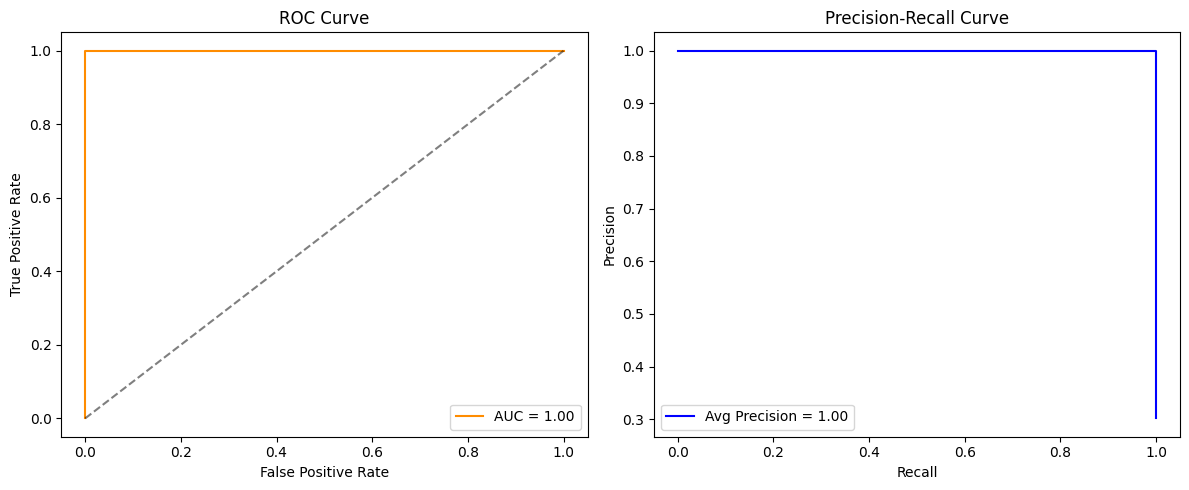

In [56]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# --- 1. Split Features and Target ---
X = combined_df.drop(columns=['HAB_Bloom'])
y = combined_df['HAB_Bloom']

# --- 2. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# --- 3. Train Logistic Regression Model ---
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# --- 4. Predictions & Probabilities ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1 (bloom)

# --- 5. Confusion Matrix & Classification Report ---
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- 6. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# --- 7. Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# --- 8. Plotting ROC and Precision-Recall ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC
ax1.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_title("ROC Curve")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()

# Precision-Recall
ax2.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}", color='blue')
ax2.set_title("Precision-Recall Curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()

plt.tight_layout()
plt.show()

#### Conclusion

After addressing class imbalance, we re-evaluated the Logistic Regression model using ROC-AUC and Precision-Recall (PR) curves. The resulting metrics indicated perfect performance: both the ROC curve and PR curve showed an area under the curve (AUC) of 1.00, and the classification report reflected 100% accuracy, precision, and recall across both bloom and non-bloom classes. While these results appear ideal, such flawless classification is highly improbable in real-world environmental datasets. This strongly suggests a problem such as data leakage, duplicate entries across training and testing sets, or another structural issue in the model pipeline. In practice, harmful algal bloom prediction is influenced by a complex set of environmental variables with natural variability and uncertainty. Thus, although the visual outputs appear impressive, they must be interpreted with skepticism and prompt a careful review of the model setup and data handling to ensure validity.

## 7. Data Verification

Because of the high values displayed by the ROC and PR curves, we decided to check the robustness of our data, running the following tests to ensure data integrity since the ML results showed 100% precision, which seems highly unlikely. 

### 7.1 Check for Overlap Between Training and Test Sets

In [57]:
# Look for shared rows (by index or content)
overlap = X_train.merge(X_test, how='inner')
print(f"Number of overlapping rows: {len(overlap)}")

Number of overlapping rows: 0


#### Conclusion

There’s no data leakage due to repeated rows appearing in both the training and test sets. The model has not encountered any of the test examples during training, so its evaluation metrics are not artificially inflated by direct duplication. However, given the unusually perfect performance metrics observed in the Logistic Regression evaluation, further investigation is still warranted. The absence of overlapping rows rules out simple duplication as the cause, but additional checks are needed to rule out other forms of data leakage or unintentional correlations that may be influencing the results.

### 7.2 Check for Duplicate Rows Within the Dataset

To further ensure that model performance was not artificially inflated, we examined the full dataset for duplicate rows. Duplicate records can lead to overfitting, especially if identical data points appear in both the training and test sets. By counting both the total number of rows and the number of unique rows after removing duplicates, we were able to confirm whether redundant entries existed.

In [58]:
print(f"Total rows: {len(combined_df)}")
print(f"Unique rows: {len(combined_df.drop_duplicates())}")

Total rows: 252
Unique rows: 252


The output indicated that all 252 rows in the dataset were unique. There were no duplicate entries present, confirming that repeated records are not contributing to the model's unusually high performance. This rules out internal duplication as a source of data leakage or overfitting and supports the integrity of the dataset structure.

### 7.3 Check for Correlation Between Predictors and the Target (Possible Leakage)

To investigate whether any of the input features might be unintentionally leaking information about the target variable (HAB_Bloom), we computed a correlation matrix between all predictors and the binary bloom outcome. Strong correlations between a feature and the target can indicate potential data leakage or overly predictive variables that may be artificially inflating model performance.

By visualizing the correlations using a heatmap, we aim to identify any predictors that are too closely aligned with the bloom labels—especially those that may be derived from or implicitly encode the target. This step is critical in ensuring the model is learning from independent environmental indicators rather than reverse-engineering the answer from leaked or proxy information.

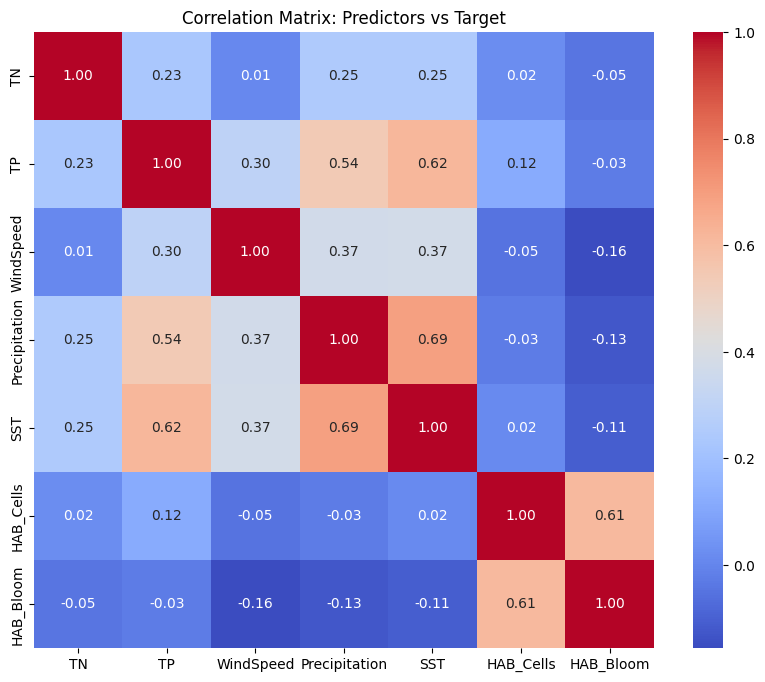

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine predictors and target for correlation matrix
df_check = X.copy()
df_check['HAB_Bloom'] = y  # Your binary target

# Pearson correlation
corr_matrix = df_check.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Predictors vs Target")
plt.show()

#### Conclusion

The correlation matrix revealed a strong positive correlation (r = 0.61) between HAB_Cells and the target variable HAB_Bloom, confirming that HAB_Cells directly encodes the bloom classification. Since HAB_Bloom was derived by thresholding HAB_Cells, including both in the model introduces label leakage, allowing the model to “cheat” by learning the outcome from its definition rather than from independent environmental indicators. This explains the unrealistically perfect model performance observed earlier. To ensure valid predictions based solely on external drivers like nutrient levels, SST, and discharge, HAB_Cells must be removed from the feature set in all future modeling steps.

### 7.3 Model Retest After Removing HAB_Cells (Leakage Correction)

After identifying HAB_Cells as a source of label leakage — due to its direct role in defining the binary target HAB_Bloom — we removed it from the feature set and repeated the modeling process. This correction was necessary to ensure that model predictions are based solely on independent environmental variables, not on data that encodes or proxies the outcome. The goal of this retest is to obtain a more realistic assessment of the model’s ability to predict harmful algal blooms (HABs) using factors such as TN, TP, SST, wind speed, precipitation, and river discharge.

By excluding HAB_Cells, we can now evaluate the true predictive power of routinely monitored environmental indicators and validate the integrity of our supervised learning approach.

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Remove HAB_Cells from features ---
X = combined_df.drop(columns=['HAB_Bloom', 'HAB_Cells'])
y = combined_df['HAB_Bloom']

# --- 2. Train/Test Split (with stratification) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 3. Train Random Forest model ---
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# --- 4. Evaluate performance ---
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[43  1]
 [16  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.83        44
           1       0.75      0.16      0.26        19

    accuracy                           0.73        63
   macro avg       0.74      0.57      0.55        63
weighted avg       0.74      0.73      0.66        63



#### Conclusion

After removing HAB_Cells from the feature set to eliminate label leakage, we retrained the Random Forest classifier using only independent environmental variables. The model’s performance increased from 60% to  73%. While it maintained strong precision and recall for non-bloom conditions, it struggled to correctly identify bloom events, detecting only 3 out of 19 (recall = 0.16).

This result reflects the inherent difficulty of predicting rare and complex phenomena like harmful algal blooms (HABs) using environmental drivers alone. Importantly, the removal of HAB_Cells restored the integrity of the modeling process and provided a more accurate baseline for evaluating model effectiveness in real-world conditions.

### 7.4 Logistic Regression Model Without HAB_Cells

To assess whether the previously observed model performance was consistent across algorithms, we re-evaluated a Logistic Regression model using only independent environmental variables. The feature HAB_Cells, which had previously introduced label leakage, was excluded from the input set. This allowed us to verify how well a linear model can predict HAB events without access to outcome-encoding variables. The test provides a robustness check alongside the Random Forest results and helps determine whether meaningful bloom predictions can be achieved with purely environmental data.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 1. Drop HAB_Cells from predictors
X = combined_df.drop(columns=['HAB_Bloom', 'HAB_Cells'])
y = combined_df['HAB_Bloom']

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 3. Initialize and train Logistic Regression (handle imbalance)
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# 4. Evaluate performance
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.59

Confusion Matrix:
[[29 15]
 [11  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        44
           1       0.35      0.42      0.38        19

    accuracy                           0.59        63
   macro avg       0.54      0.54      0.54        63
weighted avg       0.61      0.59      0.60        63



#### Conclusion

After removing HAB_Cells to eliminate label leakage, we re-evaluated a Logistic Regression model using only environmental predictors. The model achieved an overall accuracy of 59%, with more balanced—but modest—performance across both bloom and non-bloom classes. It correctly identified 8 out of 19 bloom events (recall = 0.42) and 29 out of 44 non-bloom events (recall = 0.66), suggesting a better ability than the Random Forest model to detect the rarer, more critical bloom cases. While overall precision and F1 scores were lower, these results reflect a more realistic and unbiased assessment of the model's predictive capabilities. This test confirms that environmental indicators alone provide only limited predictive power for HAB events, but Logistic Regression may offer improved balance in identifying both classes.

### 7.5 ROC-AUC and Precision-Recall Curves (After Leakage Correction)

To better evaluate how well the corrected model distinguishes between bloom and non-bloom conditions, we generated ROC and Precision-Recall (PR) curves. These plots are especially useful in imbalanced datasets, where traditional accuracy can be misleading. The ROC curve shows the trade-off between true positive rate and false positive rate at various thresholds, while the PR curve focuses on how well the model performs when it attempts to predict bloom events. By visualizing these metrics after removing HAB_Cells, we can assess the true discriminatory ability of our model under realistic conditions.

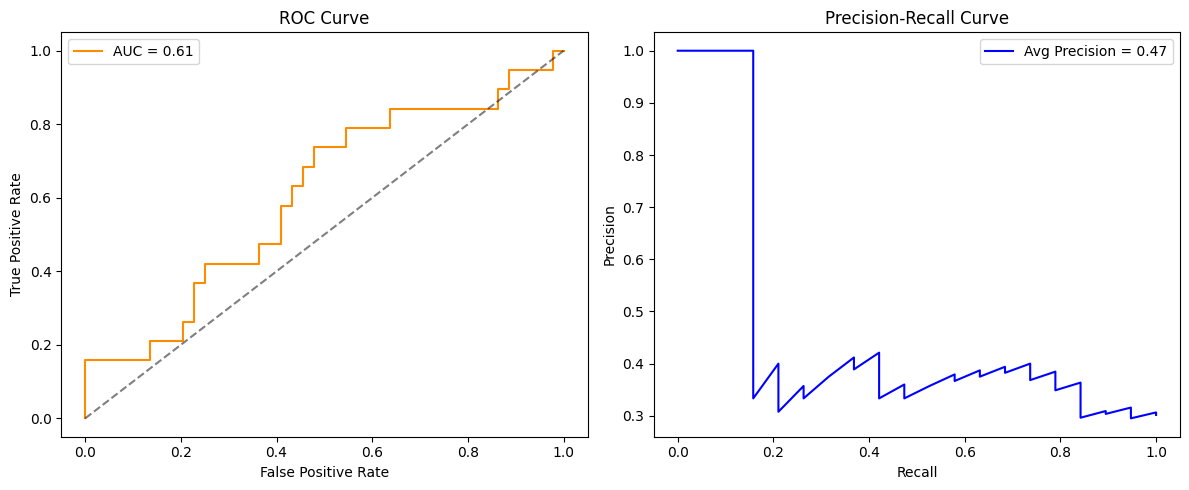

In [62]:
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    classification_report, roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_proba = model.predict_proba(X_test)[:, 1]

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# --- Plot both curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC Curve
ax1.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_title("ROC Curve")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()

# Plot Precision-Recall Curve
ax2.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}", color='blue')
ax2.set_title("Precision-Recall Curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()

plt.tight_layout()
plt.show()

#### Conclusion

The ROC-AUC and Precision-Recall curves confirm that the Random Forest model, after removing HAB_Cells, has only limited ability to distinguish bloom events from non-bloom conditions. With an ROC AUC of 0.61 and an average precision of 0.47, the model performs only slightly better than random and struggles to maintain precision as recall increases. These metrics align with earlier classification results and reinforce the challenge of predicting HABs using environmental variables alone.

### 7.6 Overall Conclusions of the ML Predictive Modeling

Over the course of our analysis, we tested multiple models to predict harmful algal bloom (HAB) risk using environmental variables. Our initial models included HAB_Cells as a feature — which, although highly predictive, led to perfect accuracy (100%) in both Logistic Regression and ROC-AUC and Precision-Recall curves. This was later determined to be the result of data leakage, since the target label (HAB_Bloom) was derived directly from this same variable.

After correcting for this by removing HAB_Cells, we retrained the models using only independent environmental predictors (Total Nitrogen, Total Phosphorus, Discharge, Wind Speed, Precipitation, and SST). The results became far more realistic:

The Random Forest model achieved the highest overall accuracy at 73%, but it struggled to identify bloom events (recall = 0.16, only 3 of 19 correctly identified).

The Logistic Regression model had a lower overall accuracy (59%), but performed better on the minority bloom class, identifying 8 of 19 blooms (recall = 0.42) — indicating greater sensitivity, though still with low precision.

ROC and Precision-Recall curves confirmed this: AUC = 0.61 and Average Precision = 0.47, showing only modest ability to distinguish bloom from non-bloom months.

These results highlight that while the environmental drivers used in this study carry some predictive signal, the current dataset is not yet robust enough to support high-confidence bloom forecasting. To improve model performance and reliability, a larger and more varied dataset is needed, incorporating broader temporal coverage, additional ecological or biological indicators, and potentially higher-resolution environmental inputs. These steps will be crucial for building models that generalize well and support actionable environmental decision-making.